In [116]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc
class CFG:
    EPOCHS = 20 
    BATCH_SIZE = 32
    SEED = 42
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

In [117]:
DATASET_PATH = "/kaggle/input/snake-species-resize-dataset/Snake_Species_Dataset/"


In [118]:
%%time
dataset_images = glob.glob(f"{DATASET_PATH}**/*.jpg")

CPU times: user 15.9 ms, sys: 3.7 ms, total: 19.6 ms
Wall time: 113 ms


In [119]:
# Get dataset size
total = len(dataset_images)

# View samples counts
print(f'TOTAL: {total}')

TOTAL: 4489


In [120]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]


def build_df(image_paths, labels):
    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })
    
    # Shuffle and return df
    return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

In [121]:
# Build the Dataset DataFrame 
dataset_df = build_df(dataset_images, generate_labels(dataset_images))

In [122]:
# View first 5 samples in the dataset
dataset_df.head(5)

image_path                label
0  /kaggle/input/snake-species-resize-dataset/Sna...  Greater Black Krait
1  /kaggle/input/snake-species-resize-dataset/Sna...           King Cobra
2  /kaggle/input/snake-species-resize-dataset/Sna...        Russels Viper
3  /kaggle/input/snake-species-resize-dataset/Sna...        Russels Viper
4  /kaggle/input/snake-species-resize-dataset/Sna...        Russels Viper

In [123]:
# Generate Label Encoder
label_encoder = LabelEncoder()

# Label Encode the Image Labels
dataset_df['label_encoded'] = label_encoder.fit_transform(dataset_df.label)

# View first 10 samples
dataset_df.head(10)

image_path                label  \
0  /kaggle/input/snake-species-resize-dataset/Sna...  Greater Black Krait   
1  /kaggle/input/snake-species-resize-dataset/Sna...           King Cobra   
2  /kaggle/input/snake-species-resize-dataset/Sna...        Russels Viper   
3  /kaggle/input/snake-species-resize-dataset/Sna...        Russels Viper   
4  /kaggle/input/snake-species-resize-dataset/Sna...        Russels Viper   
5  /kaggle/input/snake-species-resize-dataset/Sna...        Russels Viper   
6  /kaggle/input/snake-species-resize-dataset/Sna...     Binoellate Cobra   
7  /kaggle/input/snake-species-resize-dataset/Sna...          Walls Krait   
8  /kaggle/input/snake-species-resize-dataset/Sna...         Common Krait   
9  /kaggle/input/snake-species-resize-dataset/Sna...     Binoellate Cobra   

   label_encoded  
0              3  
1              5  
2              9  
3              9  
4              9  
5              9  
6              1  
7             10  
8              2  
9              1

In [124]:
# Get class names and number of classes from label_encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 11
Classes: ['Banded Krait' 'Binoellate Cobra' 'Common Krait' 'Greater Black Krait'
 'Green Pit Viper' 'King Cobra' 'Lesser Black Krait' 'Monocellate Cobra'
 'Red Tailed Pit' 'Russels Viper' 'Walls Krait']


In [125]:
def _load(image_path):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    
    # Resize image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH],
                            method=tf.image.ResizeMethod.LANCZOS3)
    
    # Convert image dtype to float32 and NORMALIZE!!!
    image = tf.cast(image, tf.float32)/255.
    
    # Return image
    return image

def view_sample(image, label, color_map='gray', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)
    plt.imshow(tf.image.rgb_to_grayscale(image), cmap=color_map)
    plt.title(f'Label: {label}', fontsize=16)
#     plt.savefig(f'/kaggle/working/{label}.jpg')
    return

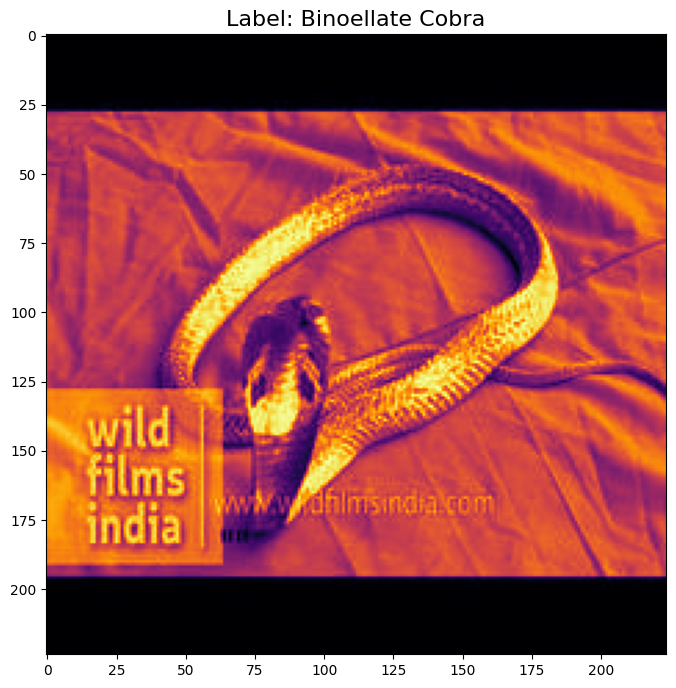

In [126]:
# Select random sample from train_df
idx = random.sample(dataset_df.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_label = _load(dataset_df.image_path[idx]), dataset_df.label[idx]

# View the random sample
view_sample(sample_image, sample_label, color_map='inferno')

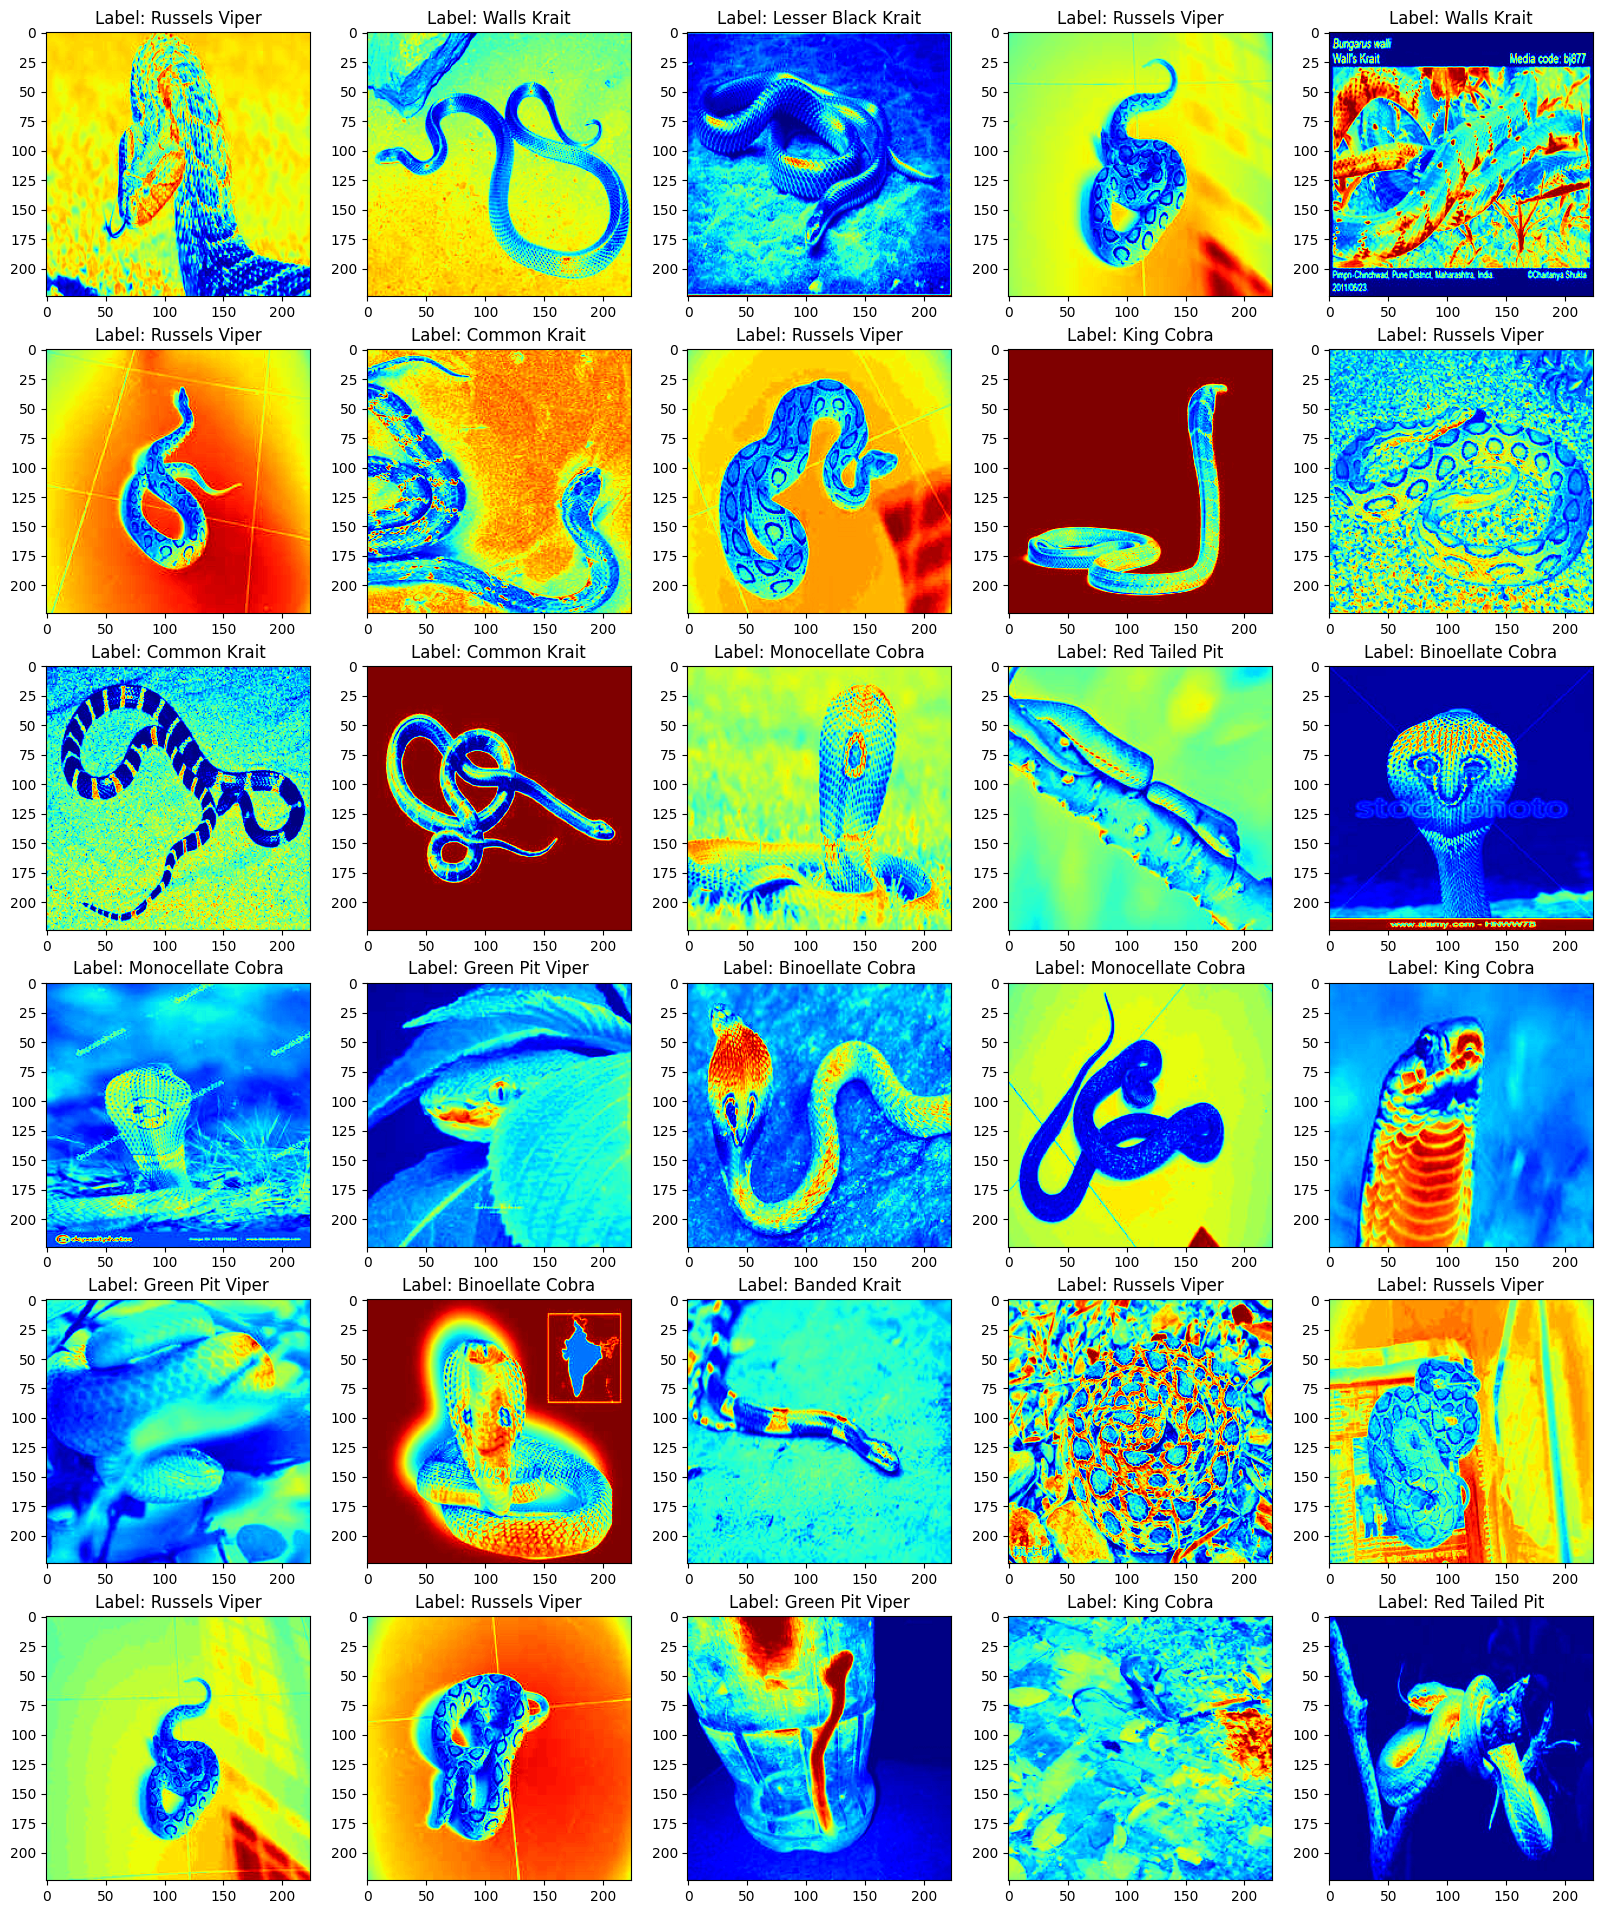

In [127]:
def view_mulitiple_samples(df, sample_loader, count=10, color_map='gray', fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1
    
    idx = random.sample(df.index.to_list(), count)    
    fig = plt.figure(figsize=fig_size)

    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column+1)
        plt.title(f'Label: {df.label[_]}')
        plt.imshow(tf.image.rgb_to_grayscale(sample_loader(df.image_path[_])), cmap=color_map);
    
    return

view_mulitiple_samples(dataset_df, _load, 
                       count=30, color_map='jet', 
                       fig_size=(20, 24))

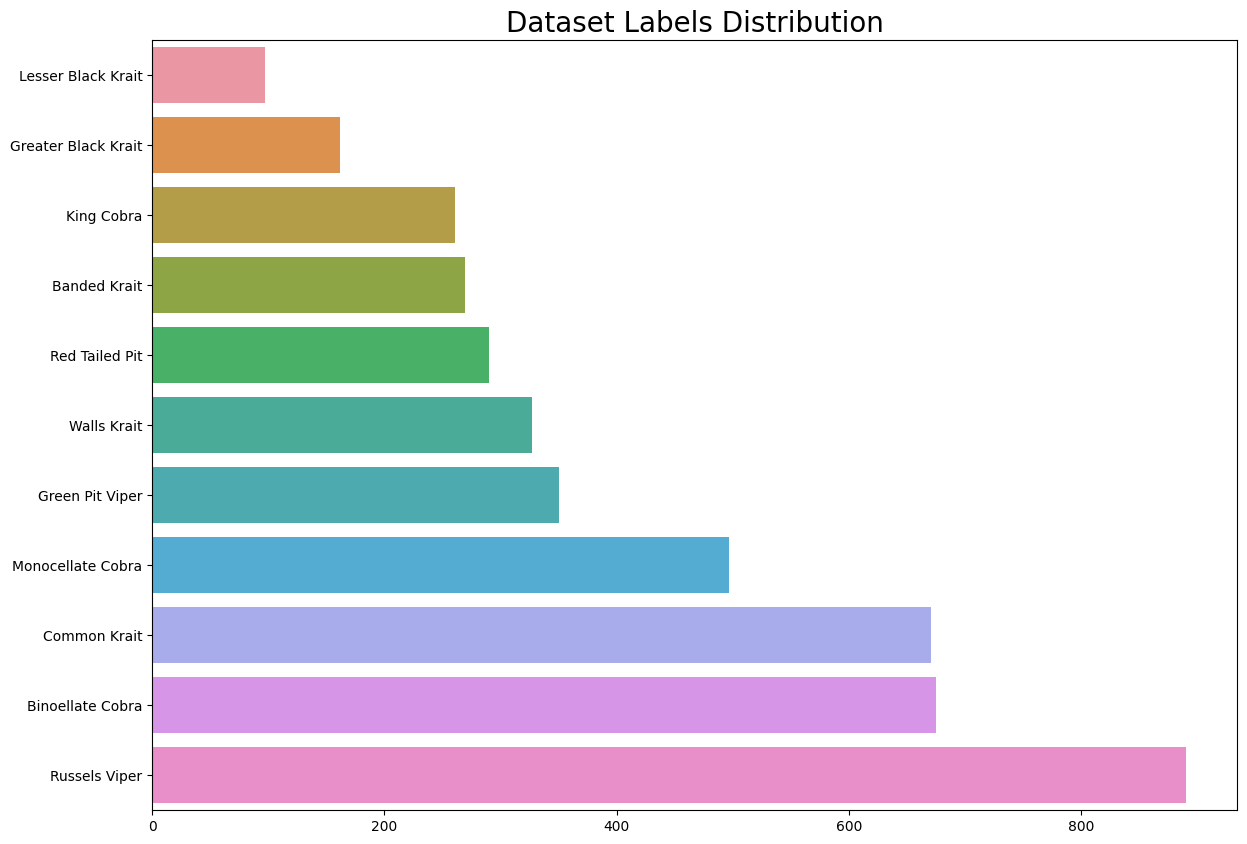

In [128]:
# Generate Figure
fig = plt.figure(figsize=(14, 10))

# Plot Labels Distribution
plt.title('Dataset Labels Distribution', fontsize=20)
distribution = dataset_df['label'].value_counts().sort_values()
sns.barplot(x=distribution.values,
            y=list(distribution.keys()),
            orient="h");


In [129]:
# Get insufficient labels
insufficient_labels = list(distribution[distribution.values < 10].keys())

# # Get insufficient labels indices from df
# insufficient_indices = pd.concat([dataset_df[dataset_df.label == _] for _ in insufficient_labels]).index

# # Remove insufficient labels
# dataset_df = dataset_df.drop(insufficient_indices).reset_index(drop=True)

In [130]:
dataset_df['label'].value_counts().sort_values()

label
Lesser Black Krait      97
Greater Black Krait    162
King Cobra             261
Banded Krait           269
Red Tailed Pit         290
Walls Krait            327
Green Pit Viper        350
Monocellate Cobra      497
Common Krait           671
Binoellate Cobra       675
Russels Viper          890
Name: count, dtype: int64

# 2 | Data Preprocessing: Building An Input Data Pipeline

In [131]:
# Generate Label Encoder
label_encoder = LabelEncoder()

# Label Encode the Image Labels
dataset_df['label_encoded'] = label_encoder.fit_transform(dataset_df.label)

# View first 10 samples
dataset_df.head(10)

image_path                label  \
0  /kaggle/input/snake-species-resize-dataset/Sna...  Greater Black Krait   
1  /kaggle/input/snake-species-resize-dataset/Sna...           King Cobra   
2  /kaggle/input/snake-species-resize-dataset/Sna...        Russels Viper   
3  /kaggle/input/snake-species-resize-dataset/Sna...        Russels Viper   
4  /kaggle/input/snake-species-resize-dataset/Sna...        Russels Viper   
5  /kaggle/input/snake-species-resize-dataset/Sna...        Russels Viper   
6  /kaggle/input/snake-species-resize-dataset/Sna...     Binoellate Cobra   
7  /kaggle/input/snake-species-resize-dataset/Sna...          Walls Krait   
8  /kaggle/input/snake-species-resize-dataset/Sna...         Common Krait   
9  /kaggle/input/snake-species-resize-dataset/Sna...     Binoellate Cobra   

   label_encoded  
0              3  
1              5  
2              9  
3              9  
4              9  
5              9  
6              1  
7             10  
8              2  
9              1

In [132]:
# Get class names and number of classes from label_encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 11
Classes: ['Banded Krait' 'Binoellate Cobra' 'Common Krait' 'Greater Black Krait'
 'Green Pit Viper' 'King Cobra' 'Lesser Black Krait' 'Monocellate Cobra'
 'Red Tailed Pit' 'Russels Viper' 'Walls Krait']


In [133]:
# Create Train/Test split with Training Set
train_split_idx, val_test_split_idx, _, _ = train_test_split(dataset_df.index, 
                                                        dataset_df.label_encoded, 
                                                        test_size=0.4,
                                                        stratify=dataset_df.label_encoded,
                                                        random_state=CFG.SEED)

In [134]:
# Get training and validation data
train_df = dataset_df.iloc[train_split_idx].reset_index(drop=True)
val_test_df = dataset_df.iloc[val_test_split_idx].reset_index(drop=True)

# View shapes
train_df.shape, val_test_df.shape

((2693, 3), (1796, 3))

In [135]:
# Create Train/Test split with Training Set
val_split_idx, test_split_idx, _, _ = train_test_split(val_test_df.index, 
                                                       val_test_df.label_encoded, 
                                                       test_size=0.6,
                                                       stratify=val_test_df.label_encoded,
                                                       random_state=CFG.SEED)

In [136]:
# Get validation and test data
val_df = dataset_df.iloc[val_split_idx].reset_index(drop=True)
test_df = dataset_df.iloc[test_split_idx].reset_index(drop=True)

# View shapes
val_df.shape, test_df.shape

((718, 3), (1078, 3))

In [137]:
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size + test_size

# View the counts
print(f'train samples count:\t\t{train_size}')
print(f'validation samples count:\t{val_size}')
print(f'test samples count:\t\t{test_size}')
print('=======================================')
print(f'TOTAL:\t\t\t\t{total}')

train samples count:		2693
validation samples count:	718
test samples count:		1078
TOTAL:				4489


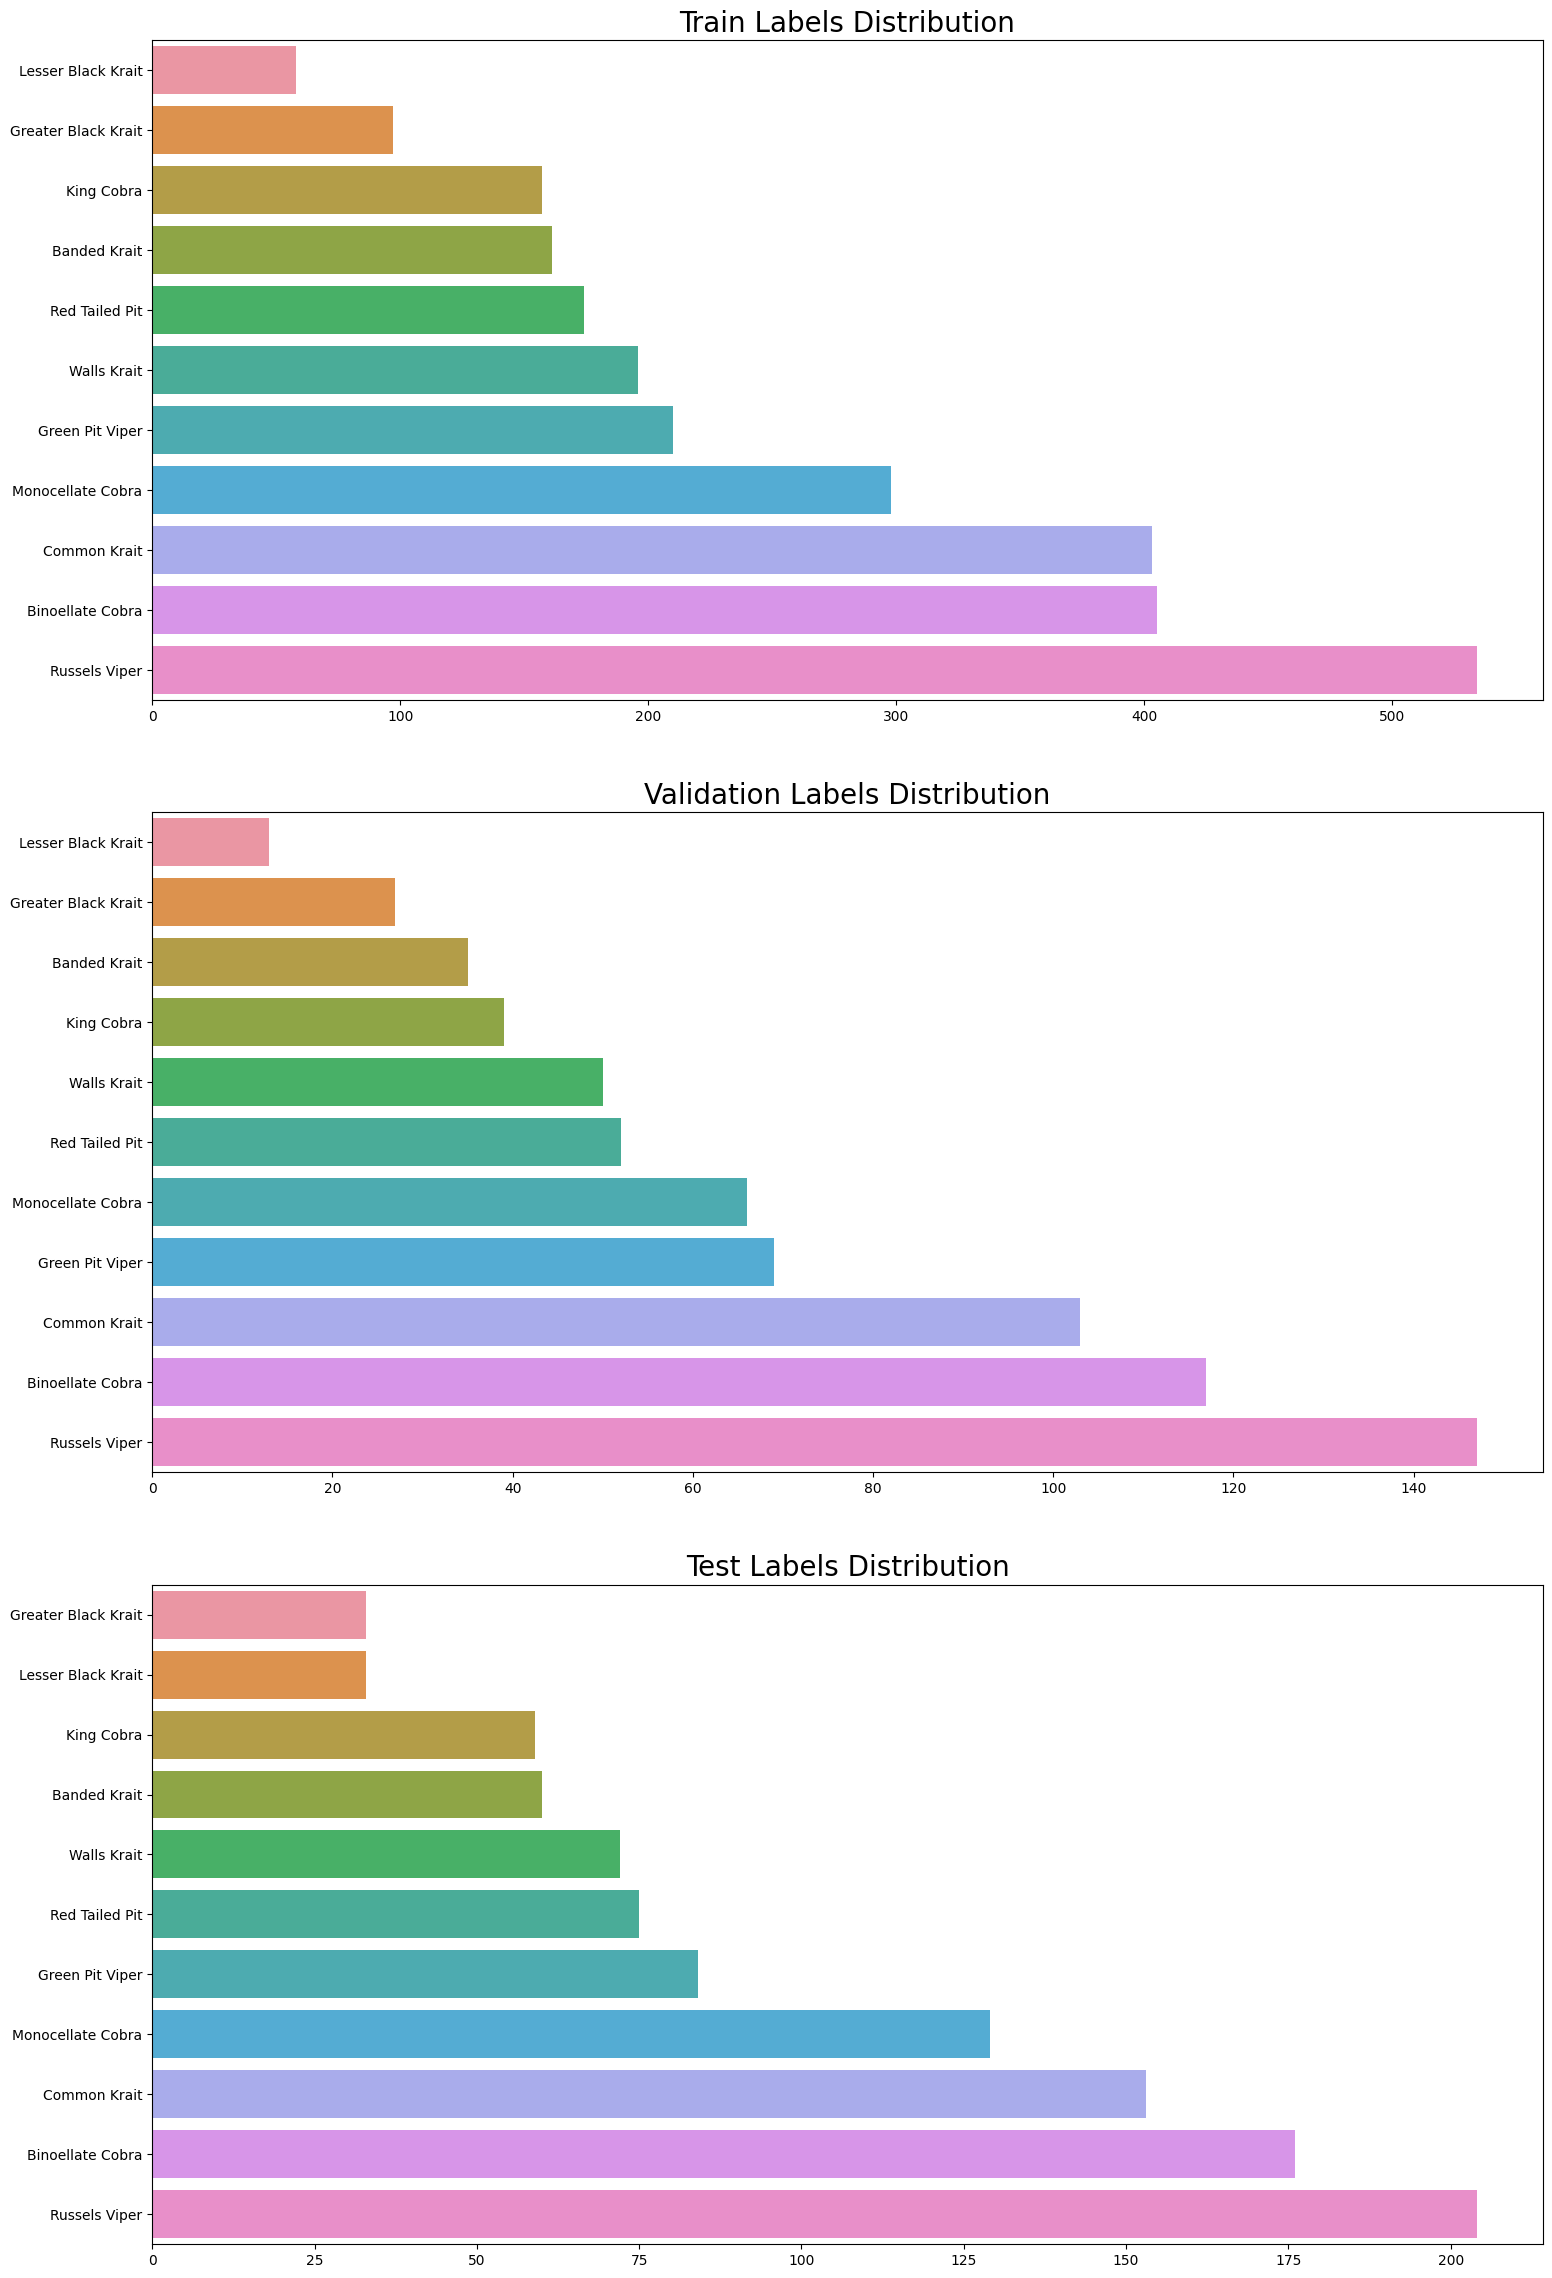

In [138]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 24))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=20)
train_distribution = train_df['label'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h",
            ax=ax1);

# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=20)
val_distribution = val_df['label'].value_counts().sort_values()
sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h",
            ax=ax2);

# Plot Test Labels Distribution
ax3.set_title('Test Labels Distribution', fontsize=20)
test_distribution = test_df['label'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            orient="h",
            ax=ax3);

In [139]:
# Build augmentation layer
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED),
    layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED),
    layers.RandomRotation(factor=0.1, seed=CFG.TF_SEED),
    layers.RandomContrast(factor=0.1, seed=CFG.TF_SEED),

], name='augmentation_layer')

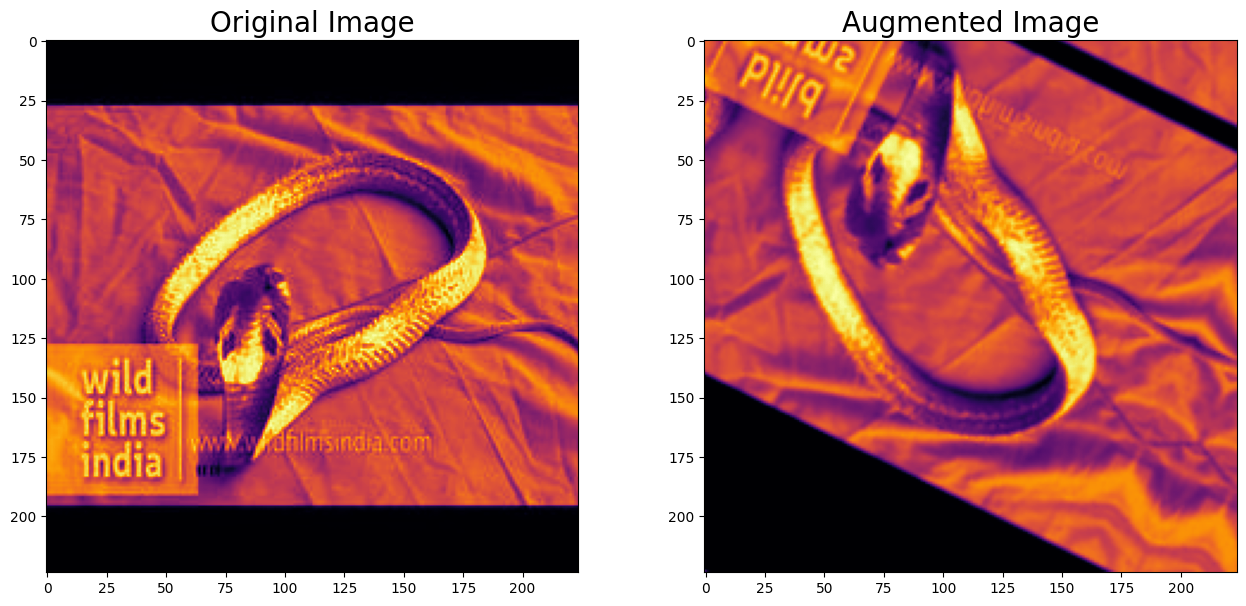

In [140]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View Original Image
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(tf.image.rgb_to_grayscale(sample_image), cmap='inferno');

# View Augmented Image
ax2.set_title('Augmented Image', fontsize=20)
ax2.imshow(tf.image.rgb_to_grayscale(augmentation_layer(sample_image)), cmap='inferno');
plt.savefig(f'/kaggle/working/augmented_image.jpg')

In [141]:
def encode_labels(labels, encode_depth=11):
    return tf.one_hot(labels, depth=encode_depth).numpy()

def create_pipeline(df, load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    
    # Get image paths and labels from DataFrame
    image_paths = df.image_path
    image_labels = encode_labels(df.label_encoded)
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Create dataset with raw data from DataFrame
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
    
    # Map augmentation layer and load function to dataset inputs if augment is True
    # Else map only the load function
    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (load_function(x), y), num_parallel_calls=AUTOTUNE)
    
    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    # Apply batching
    ds = ds.batch(batch_size)
    
    # Apply caching based on condition
    # Note: Use cache in memory (cache='') if the data is small enough to fit in memory!!!
    if cache != None:
        ds = ds.cache(cache)
    
    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    # Return the dataset
    return ds

In [142]:
# Generate Train Input Pipeline
train_ds = create_pipeline(train_df, _load, augment=True, 
                           batch_size=CFG.BATCH_SIZE, 
                           shuffle=False, prefetch=True)

# Generate Validation Input Pipeline
val_ds = create_pipeline(val_df, _load, 
                         batch_size=CFG.BATCH_SIZE, 
                         shuffle=False, prefetch=False)

# Generate Test Input Pipeline
test_ds = create_pipeline(test_df, _load, 
                          batch_size=CFG.BATCH_SIZE, 
                          shuffle=False, prefetch=False)

In [143]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 11), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 11), dtype=tf.float32, name=None))>
Test Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 11), dtype=tf.float32, name=None))>


# 3 |Transfer Learning Model:

In [144]:
# Here's a function to get any model/preprocessor from tensorflow hub
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

### Get DenseNet From TensorFlow Hub

In [145]:

def getImgTensor(img_d):
    return (img_d, img_d, 3)
densenet169 = tf.keras.applications.DenseNet169(weights='imagenet', input_shape=getImgTensor(224), include_top=False)
densenet169.trainable = False

model_densenet = tf.keras.models.Sequential([
                             densenet169,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.25),
                            #  k.layers.Dense(128, activation='relu'),
                            #  k.layers.BatchNormalization(),
                            #  k.layers.Dropout(0.2),
                             tf.keras.layers.Dense(11, activation='softmax')
])
print(model_densenet.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d_2   (None, 1664)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_7 (Dropout)         (None, 1664)              0         
                                                                 
 dense_13 (Dense)            (None, 256)               426240    
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 256)              

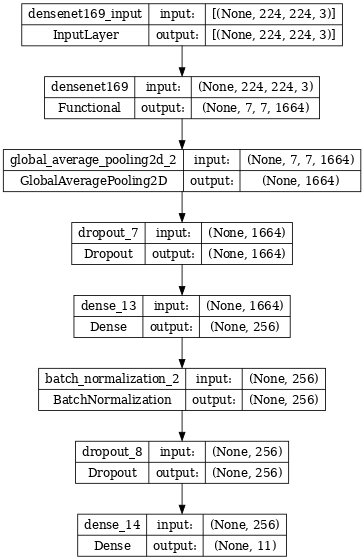

In [146]:
# Explore model visually
plot_model(
    model_densenet, dpi=60,
    show_shapes=True
)

In [147]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, tf_valid_data=None, shuffling=False, model_name="model"):
    
    model_history = {}
    
    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
#         model.save(f"/kaggle/working/{model_name}.h5")
        
    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

In [148]:
# Define Early Stopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True)

# Define Reduce Learning Rate Callback
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

# Define Callbacks and Metrics lists
CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

In [149]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_densenet.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model 
print(f'Training {model_densenet.name}.')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

densenet_history = train_model(
    model_densenet, CFG.EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False,
    model_name = "h5_densenet"
)

Training sequential_2.
Train on 2693 samples, validate on 718 samples.
----------------------------------
Epoch 1/20
85/85 [==============================] - 51s 496ms/step - loss: 1.6302 - accuracy: 0.4824 - val_loss: 0.9476 - val_accuracy: 0.6643 - lr: 0.0010
Epoch 2/20
85/85 [==============================] - 39s 459ms/step - loss: 1.0691 - accuracy: 0.6201 - val_loss: 0.7289 - val_accuracy: 0.7173 - lr: 0.0010
Epoch 3/20
85/85 [==============================] - 39s 456ms/step - loss: 0.9646 - accuracy: 0.6528 - val_loss: 0.6425 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 4/20
85/85 [==============================] - 39s 464ms/step - loss: 0.9097 - accuracy: 0.6758 - val_loss: 0.5986 - val_accuracy: 0.7549 - lr: 0.0010
Epoch 5/20
85/85 [==============================] - 39s 456ms/step - loss: 0.8506 - accuracy: 0.6877 - val_loss: 0.5789 - val_accuracy: 0.7646 - lr: 0.0010
Epoch 6/20
85/85 [==============================] - 39s 460ms/step - loss: 0.8298 - accuracy: 0.6881 - val_loss: 0

In [150]:
# Evaluate the model
densenet_evaluation = model_densenet.evaluate(test_ds)

34/34 [==============================] - 4s 103ms/step - loss: 0.5217 - accuracy: 0.7931


In [151]:
# Generate model probabilities and associated predictions
densenet_test_probabilities = model_densenet.predict(test_ds, verbose=1)
densenet_test_predictions = tf.argmax(densenet_test_probabilities, axis=1)

34/34 [==============================] - 45s 109ms/step


In [152]:
from IPython.display import FileLink
FileLink(r'densenet.h5')

/kaggle/working/densenet.h5

### Get VGG16 From TensorFlow Hub

In [153]:

def getImgTensor(img_d):
    return (img_d, img_d, 3)
vgg16 = tf.keras.applications.VGG16(weights='imagenet', 
                                                input_shape=getImgTensor(224), 
                                                include_top=False)
vgg16.trainable = False

model_vgg16 = tf.keras.models.Sequential([
                             vgg16,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.25),
                            #  k.layers.Dense(128, activation='relu'),
                            #  k.layers.BatchNormalization(),
                            #  k.layers.Dropout(0.2),
                             tf.keras.layers.Dense(11, activation='softmax')
])
print(model_vgg16.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 256)              

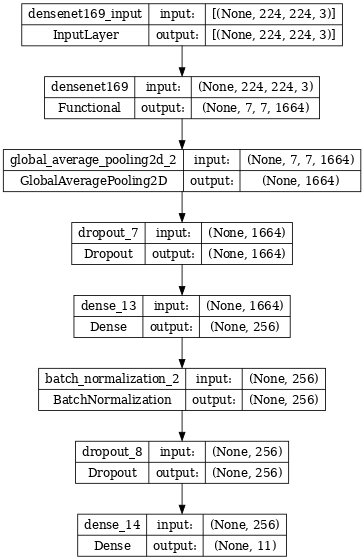

In [154]:
# Explore model visually
plot_model(
    model_densenet, dpi=60,
    show_shapes=True
)

In [155]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_vgg16.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model 
print(f'Training {model_vgg16.name}.')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

vgg16_history = train_model(
    model_vgg16, CFG.EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False,
    model_name = "h5_vgg16"
)

Training sequential_3.
Train on 2693 samples, validate on 718 samples.
----------------------------------
Epoch 1/20
85/85 [==============================] - 41s 457ms/step - loss: 2.3778 - accuracy: 0.2410 - val_loss: 2.3526 - val_accuracy: 0.1574 - lr: 0.0010
Epoch 2/20
85/85 [==============================] - 39s 456ms/step - loss: 1.9194 - accuracy: 0.3617 - val_loss: 2.3425 - val_accuracy: 0.0919 - lr: 0.0010
Epoch 3/20
85/85 [==============================] - 40s 465ms/step - loss: 1.7479 - accuracy: 0.4118 - val_loss: 2.3195 - val_accuracy: 0.0933 - lr: 0.0010
Epoch 4/20
85/85 [==============================] - 39s 462ms/step - loss: 1.6862 - accuracy: 0.4233 - val_loss: 2.2835 - val_accuracy: 0.1100 - lr: 0.0010
Epoch 5/20
85/85 [==============================] - 38s 451ms/step - loss: 1.6478 - accuracy: 0.4445 - val_loss: 2.3250 - val_accuracy: 0.0919 - lr: 0.0010
Epoch 6/20
85/85 [==============================] - ETA: 0s - loss: 1.6046 - accuracy: 0.4478
Epoch 6: ReduceLROnP

In [156]:
# Evaluate the model
vgg16_evaluation = model_vgg16.evaluate(test_ds)

34/34 [==============================] - 3s 95ms/step - loss: 28.7139 - accuracy: 0.1280


In [157]:
# Generate model probabilities and associated predictions
vgg16_test_probabilities = model_vgg16.predict(test_ds, verbose=1)
vgg16_test_predictions = tf.argmax(vgg16_test_probabilities, axis=1)

34/34 [==============================] - 42s 112ms/step


In [158]:
from IPython.display import FileLink
FileLink(r'vgg16.h5')

/kaggle/working/vgg16.h5

### Get MobileNet From TensorFlow Hub

In [159]:
# Get mobilenet_v2  here
mobilenet_v2_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
model_name = 'mobilenet_v2'

# Set trainable to False for inference-only 
set_trainable=False

mobilenet_v2 = get_tfhub_model(mobilenet_v2_url, 
                                     model_name, 
                                     model_trainable=set_trainable)

In [160]:
def mobileNet_v2_model():
    
    initializer = tf.keras.initializers.GlorotNormal(seed=CFG.SEED)
    
    mobileNet_v2_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        mobilenet_v2,
        layers.Dropout(0.2),
        layers.Dense(512, activation='relu', kernel_initializer=initializer),
        layers.Dense(256, activation='relu', kernel_initializer=initializer),
        layers.Dense(11, dtype=tf.float32, activation='softmax', kernel_initializer=initializer)
    ], name='mobileNet_v2_sequential_model')
    
    return mobileNet_v2_sequential

In [161]:
# Generate Model
model_mobileNet_v2 = mobileNet_v2_model()

# Generate Summary of the Model
model_mobileNet_v2.summary()

Model: "mobileNet_v2_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_v2 (KerasLayer)   (None, 1280)              2257984   
                                                                 
 dropout_11 (Dropout)        (None, 1280)              0         
                                                                 
 dense_17 (Dense)            (None, 512)               655872    
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                                                 
 dense_19 (Dense)            (None, 11)                2827      
                                                                 
Total params: 3,048,011
Trainable params: 790,027
Non-trainable params: 2,257,984
_________________________________________________________________


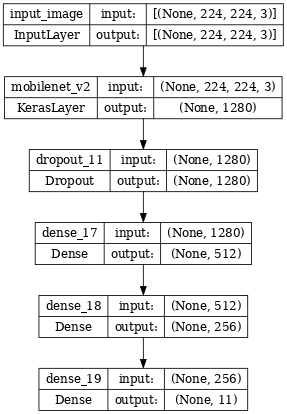

In [162]:
# Explore model visually
plot_model(
    model_mobileNet_v2, dpi=60,
    show_shapes=True
)

In [163]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_mobileNet_v2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model 
print(f'Training {model_mobileNet_v2.name}.')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

mobilenet_v2_history = train_model(
    model_mobileNet_v2, CFG.EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False,
    model_name = "h5_mobilenet"
)

Training mobileNet_v2_sequential_model.
Train on 2693 samples, validate on 718 samples.
----------------------------------
Epoch 1/20
85/85 [==============================] - 42s 423ms/step - loss: 1.2257 - accuracy: 0.5507 - val_loss: 0.8014 - val_accuracy: 0.6936 - lr: 0.0010
Epoch 2/20
85/85 [==============================] - 36s 419ms/step - loss: 0.8741 - accuracy: 0.6610 - val_loss: 0.7845 - val_accuracy: 0.6741 - lr: 0.0010
Epoch 3/20
85/85 [==============================] - 36s 420ms/step - loss: 0.7896 - accuracy: 0.6914 - val_loss: 0.6944 - val_accuracy: 0.7187 - lr: 0.0010
Epoch 4/20
85/85 [==============================] - 36s 423ms/step - loss: 0.7443 - accuracy: 0.7167 - val_loss: 0.7071 - val_accuracy: 0.7326 - lr: 0.0010
Epoch 5/20
85/85 [==============================] - 36s 427ms/step - loss: 0.6814 - accuracy: 0.7352 - val_loss: 0.6907 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 6/20
85/85 [==============================] - 36s 427ms/step - loss: 0.6417 - accuracy: 0.7

In [164]:
# Evaluate the model
mobileNet_v2_evaluation = model_mobileNet_v2.evaluate(test_ds)

34/34 [==============================] - 4s 115ms/step - loss: 0.5034 - accuracy: 0.8173


In [165]:
# Generate model probabilities and associated predictions
mobilenet_v2_test_probabilities = model_mobileNet_v2.predict(test_ds, verbose=1)
mobilenet_v2_test_predictions = tf.argmax(mobilenet_v2_test_probabilities, axis=1)

34/34 [==============================] - 4s 94ms/step


In [166]:
from IPython.display import FileLink
FileLink(r'mobilenet.h5')

/kaggle/working/mobilenet.h5

### Get ResNet From TensorFlow Hub

In [167]:
# Get resnet_v2  here
resnet_url = 'https://tfhub.dev/sayakpaul/bit_r152x2_224_feature_extraction/1'
model_name = 'resnet_v2'

# Set trainable to False for inference-only 
set_trainable=False

resnet_152 = get_tfhub_model(resnet_url, 
                                     model_name, 
                                     model_trainable=set_trainable)

In [168]:
def resnet_model():
    
    initializer = tf.keras.initializers.GlorotNormal(seed=CFG.SEED)
    
    resnet_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        resnet_152,
        layers.Dropout(0.2),
        layers.Dense(512, activation='relu', kernel_initializer=initializer),
        layers.Dense(256, activation='relu', kernel_initializer=initializer),
        layers.Dense(11, dtype=tf.float32, activation='softmax', kernel_initializer=initializer)
    ], name='resnet_sequential_model')
    
    return resnet_sequential

In [169]:
# Generate Model
model_resnet = resnet_model()

# Generate Summary of the Model
model_resnet.summary()

Model: "resnet_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet_v2 (KerasLayer)      (None, 4096)              232238208 
                                                                 
 dropout_12 (Dropout)        (None, 4096)              0         
                                                                 
 dense_20 (Dense)            (None, 512)               2097664   
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dense_22 (Dense)            (None, 11)                2827      
                                                                 
Total params: 234,470,027
Trainable params: 2,231,819
Non-trainable params: 232,238,208
_________________________________________________________________


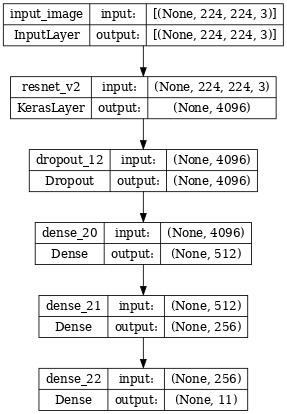

In [170]:
# Explore model visually
plot_model(
    model_resnet, dpi=60,
    show_shapes=True
)

In [171]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_resnet.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model 
print(f'Training {model_resnet.name}.')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

resnet_history = train_model(
    model_resnet, CFG.EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False,
    model_name= "h5_resnet"
)

Training resnet_sequential_model.
Train on 2693 samples, validate on 718 samples.
----------------------------------
Epoch 1/20
85/85 [==============================] - 153s 1s/step - loss: 1.6929 - accuracy: 0.5369 - val_loss: 0.7129 - val_accuracy: 0.7047 - lr: 0.0010
Epoch 2/20
85/85 [==============================] - 103s 1s/step - loss: 0.8753 - accuracy: 0.6810 - val_loss: 0.7447 - val_accuracy: 0.7228 - lr: 0.0010
Epoch 3/20
85/85 [==============================] - 108s 1s/step - loss: 0.7452 - accuracy: 0.7133 - val_loss: 0.6979 - val_accuracy: 0.7256 - lr: 0.0010
Epoch 4/20
85/85 [==============================] - 108s 1s/step - loss: 0.6809 - accuracy: 0.7312 - val_loss: 0.6825 - val_accuracy: 0.7437 - lr: 0.0010
Epoch 5/20
85/85 [==============================] - 107s 1s/step - loss: 0.6465 - accuracy: 0.7427 - val_loss: 0.5653 - val_accuracy: 0.7799 - lr: 0.0010
Epoch 6/20
85/85 [==============================] - 103s 1s/step - loss: 0.6059 - accuracy: 0.7672 - val_loss: 0.

In [172]:
# Evaluate the model
resnet_evaluation = model_resnet.evaluate(test_ds)

34/34 [==============================] - 24s 715ms/step - loss: 0.4654 - accuracy: 0.8237


In [173]:
# Generate model probabilities and associated predictions
resnet_test_probabilities = model_resnet.predict(test_ds, verbose=1)
resnet_test_predictions = tf.argmax(resnet_test_probabilities, axis=1)

34/34 [==============================] - 86s 714ms/step


In [174]:
from IPython.display import FileLink
FileLink(r'resnet.h5')

/kaggle/working/resnet.h5

### Transfer Learning Model: Vision Transformer

In [175]:
!pip install -q vit-keras

In [176]:
from vit_keras import vit

# Download the model
vit_model = vit.vit_b16(
        image_size=224,
        activation='softmax',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
        classes=11)

# Freeze model layers for inference-mode only
for layer in vit_model.layers:
    layer.trainable = False

/opt/conda/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [177]:
def vit_b16_model():
    
    initializer = tf.keras.initializers.GlorotNormal(seed=CFG.SEED)
    
    vit_b16_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        vit_model,
        layers.Dropout(0.2),
        layers.Dense(512, activation='relu', kernel_initializer=initializer),
        layers.Dense(256, activation='relu', kernel_initializer=initializer),
        layers.Dense(11, dtype=tf.float32, activation='softmax', kernel_initializer=initializer)
    ], name='vit_b16_sequential_model')
    
    return vit_b16_sequential

In [178]:
# Generate Model
model_vit_b16 = vit_b16_model()

# Generate Summary of the Model
model_vit_b16.summary()

Model: "vit_b16_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout_13 (Dropout)        (None, 768)               0         
                                                                 
 dense_23 (Dense)            (None, 512)               393728    
                                                                 
 dense_24 (Dense)            (None, 256)               131328    
                                                                 
 dense_25 (Dense)            (None, 11)                2827      
                                                                 
Total params: 86,326,539
Trainable params: 527,883
Non-trainable params: 85,798,656
_________________________________________________________________


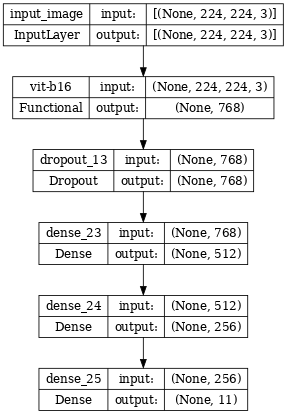

In [179]:
# Explore model visually
plot_model(
    model_vit_b16, dpi=60,
    show_shapes=True
)

In [180]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_vit_b16.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model 
print(f'Training {model_vit_b16.name}.')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

vit_b16_history = train_model(
    model_vit_b16, CFG.EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False,
    model_name = "h5_vit"
)

Training vit_b16_sequential_model.
Train on 2693 samples, validate on 718 samples.
----------------------------------
Epoch 1/20
85/85 [==============================] - 58s 541ms/step - loss: 1.2495 - accuracy: 0.5477 - val_loss: 0.7787 - val_accuracy: 0.6797 - lr: 0.0010
Epoch 2/20
85/85 [==============================] - 49s 570ms/step - loss: 0.9107 - accuracy: 0.6535 - val_loss: 0.7262 - val_accuracy: 0.6936 - lr: 0.0010
Epoch 3/20
85/85 [==============================] - 49s 570ms/step - loss: 0.8239 - accuracy: 0.6740 - val_loss: 0.6479 - val_accuracy: 0.7479 - lr: 0.0010
Epoch 4/20
85/85 [==============================] - 48s 564ms/step - loss: 0.7500 - accuracy: 0.7130 - val_loss: 0.6165 - val_accuracy: 0.7507 - lr: 0.0010
Epoch 5/20
85/85 [==============================] - 44s 513ms/step - loss: 0.6820 - accuracy: 0.7360 - val_loss: 0.6161 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 6/20
85/85 [==============================] - 49s 572ms/step - loss: 0.6624 - accuracy: 0.7475 -

In [181]:
# Evaluate the model
vit_b16_evaluation = model_vit_b16.evaluate(test_ds)

34/34 [==============================] - 9s 257ms/step - loss: 0.4853 - accuracy: 0.8089


In [182]:
# Generate model probabilities and associated predictions
vit_b16_test_probabilities = model_vit_b16.predict(test_ds, verbose=1)
vit_b16_test_predictions = tf.argmax(vit_b16_test_probabilities, axis=1)

34/34 [==============================] - 11s 257ms/step


In [183]:
from IPython.display import FileLink
FileLink(r'vit.h5')

/kaggle/working/vit.h5

### Ensemble via Averaging

In [184]:
# Compute average probabilities
avg_probabilities = np.mean([
    densenet_test_probabilities, 
    vgg16_test_probabilities, 
    mobilenet_v2_test_probabilities, 
    resnet_test_probabilities, 
    vit_b16_test_probabilities], axis=0)

# Compute average ensemble predictions
avg_predictions = tf.argmax(avg_probabilities, axis=1)

In [185]:
# Define weights and list model probabilities
weights = [0.15, 0.1, 0.25, 0.3, 0.2]
model_probabilities = [densenet_test_probabilities,
                       vgg16_test_probabilities,
                       mobilenet_v2_test_probabilities, 
                       resnet_test_probabilities, 
                       vit_b16_test_probabilities]

# Compute weighted average probabilities
weighted_avg_probabilities = sum([w * p for w, p in zip(weights, model_probabilities)])

# Compute weighted average ensemble predictions
weighted_avg_predictions = tf.argmax(weighted_avg_probabilities, axis=1)

In [186]:
# List model probabilities
model_probabilities = [densenet_test_probabilities, 
                       vgg16_test_probabilities, 
                       mobilenet_v2_test_probabilities, 
                       resnet_test_probabilities, 
                       vit_b16_test_probabilities]

# Compute geometric mean probabilities
geometric_mean_probabilities = np.power(np.multiply(np.multiply(model_probabilities[0], 
                                                    model_probabilities[1]),
                                        np.multiply(model_probabilities[2], 
                                                    model_probabilities[3], 
                                                    model_probabilities[4])),
                                        1/len(model_probabilities))

# Compute weighted average ensemble predictions
geometric_mean_predictions = tf.argmax(geometric_mean_probabilities, axis=1)

### Performance Evaluation

In [187]:
def plot_training_curves(history):
    
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

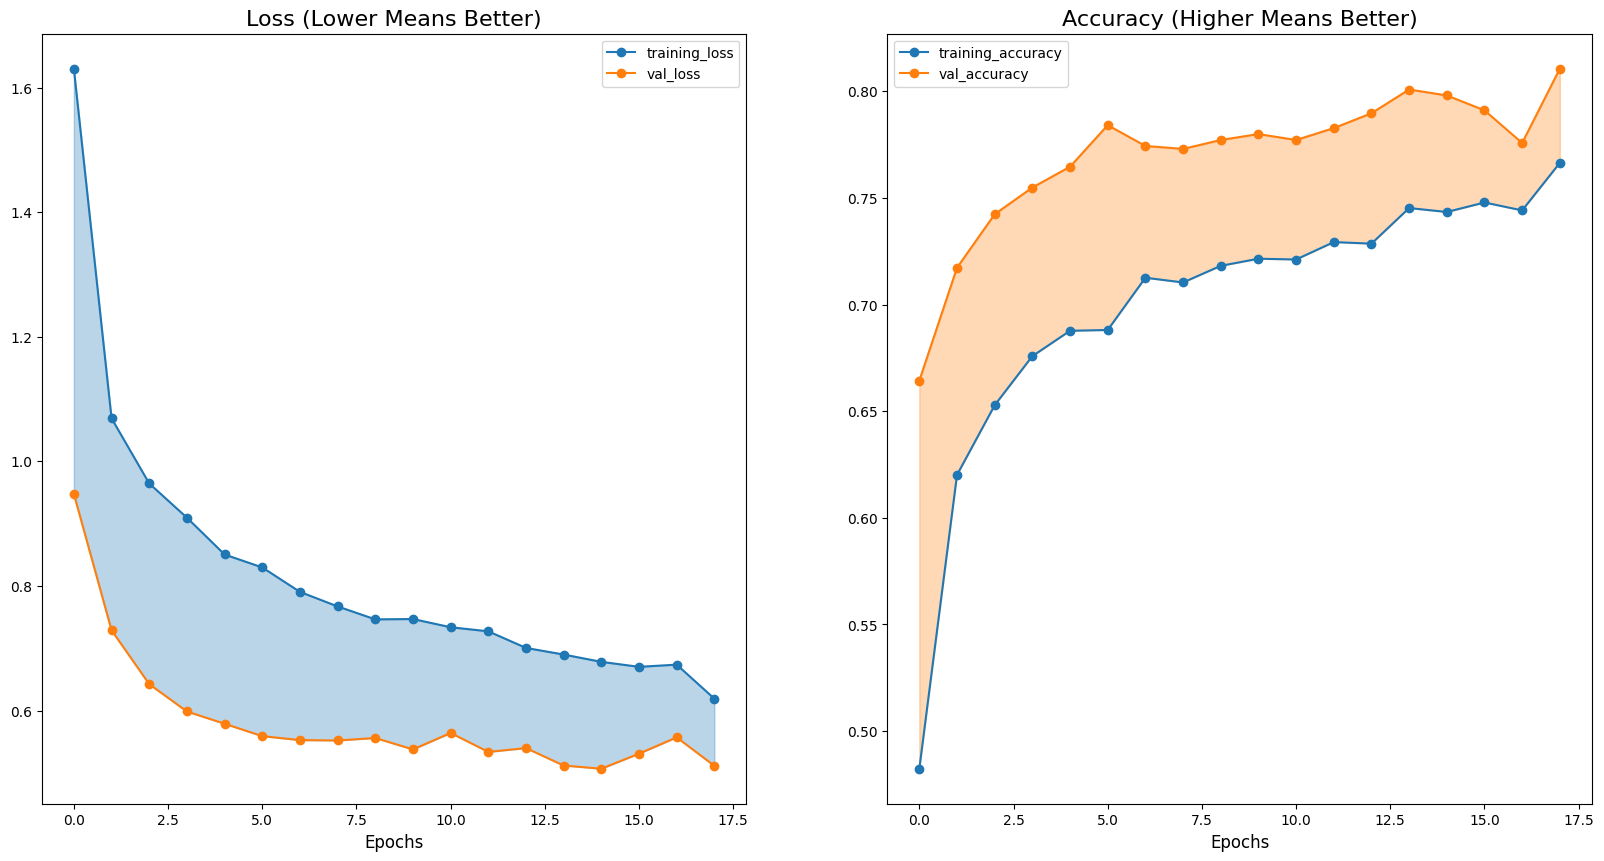

In [188]:
# Plot Densenet model training history 
plot_training_curves(densenet_history)


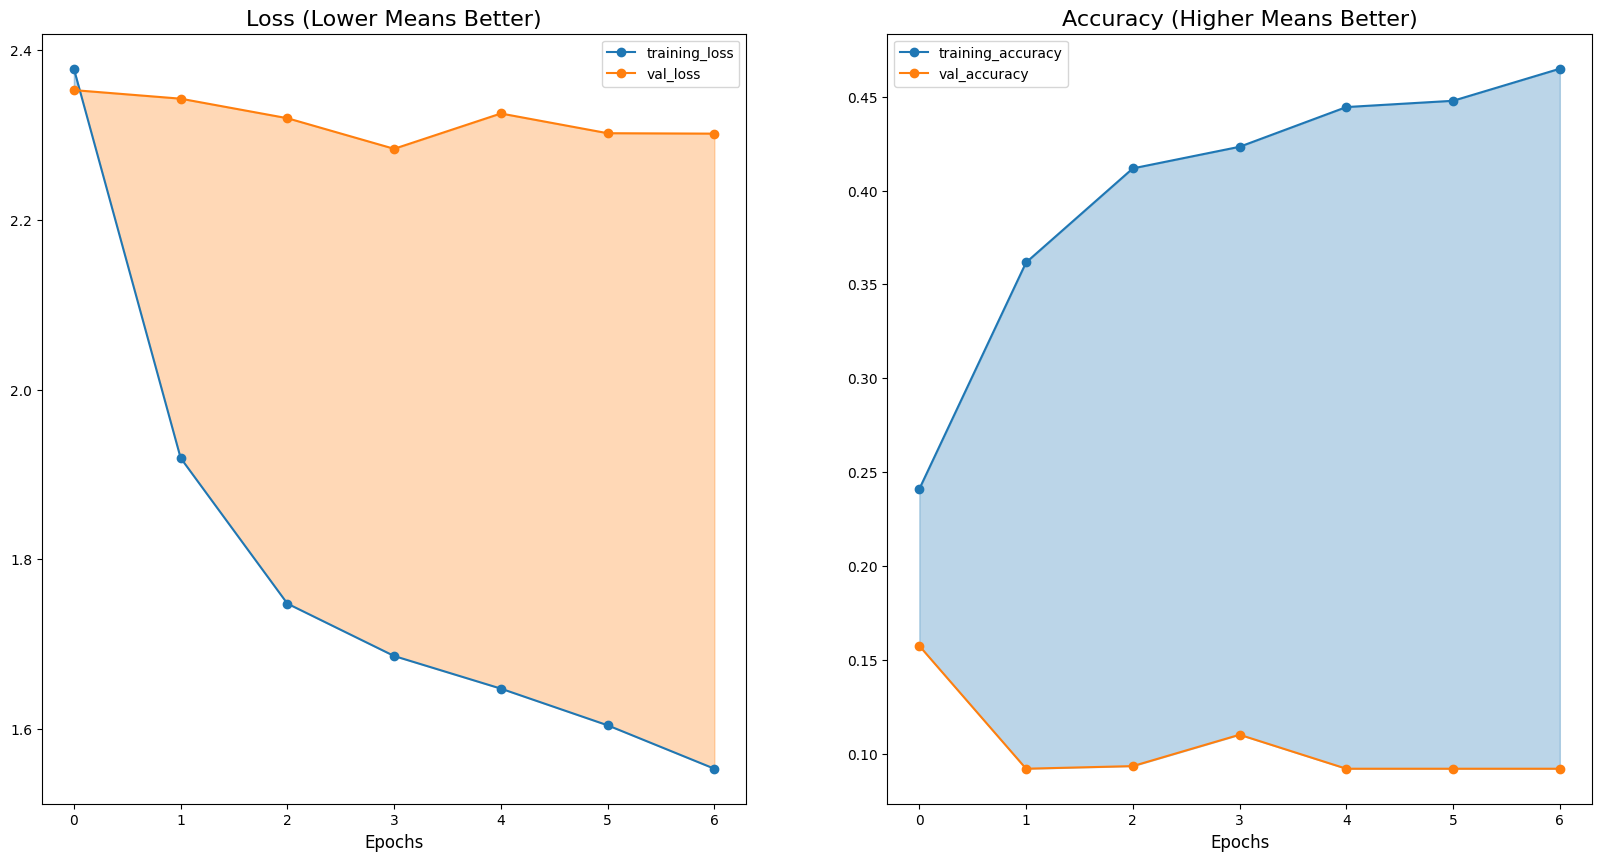

In [189]:
# Plot Vgg16 model training history 
plot_training_curves(vgg16_history)
plt.savefig(f'/kaggle/working/vgg16_graph.jpg')

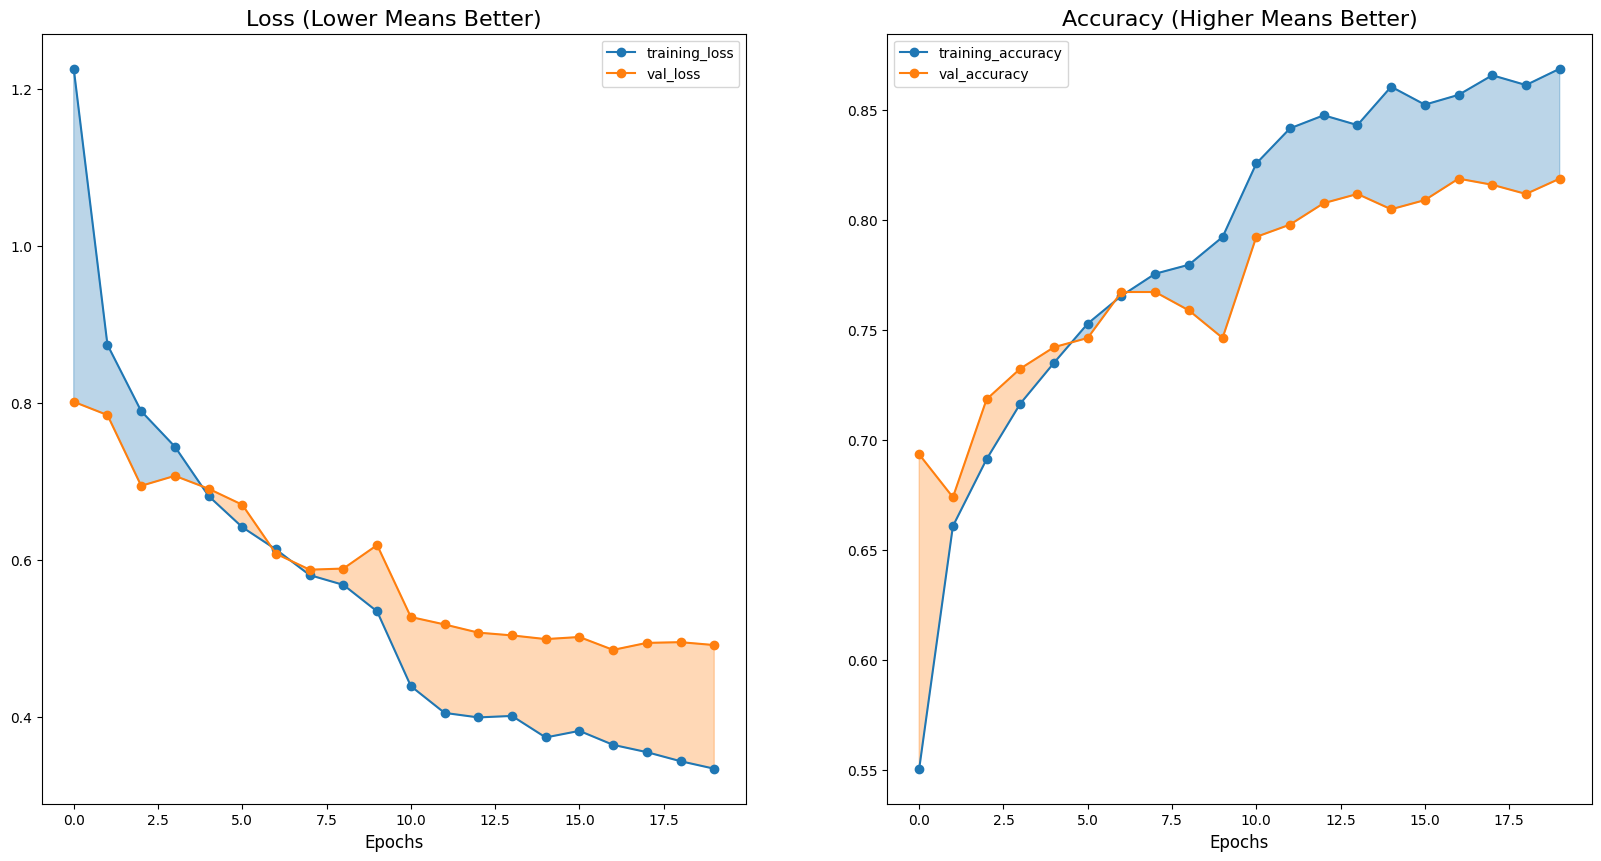

In [190]:
# Plot Mobilenet V2 model training history 
plot_training_curves(mobilenet_v2_history)
plt.savefig(f'/kaggle/working/mobilenet_graph.jpg')

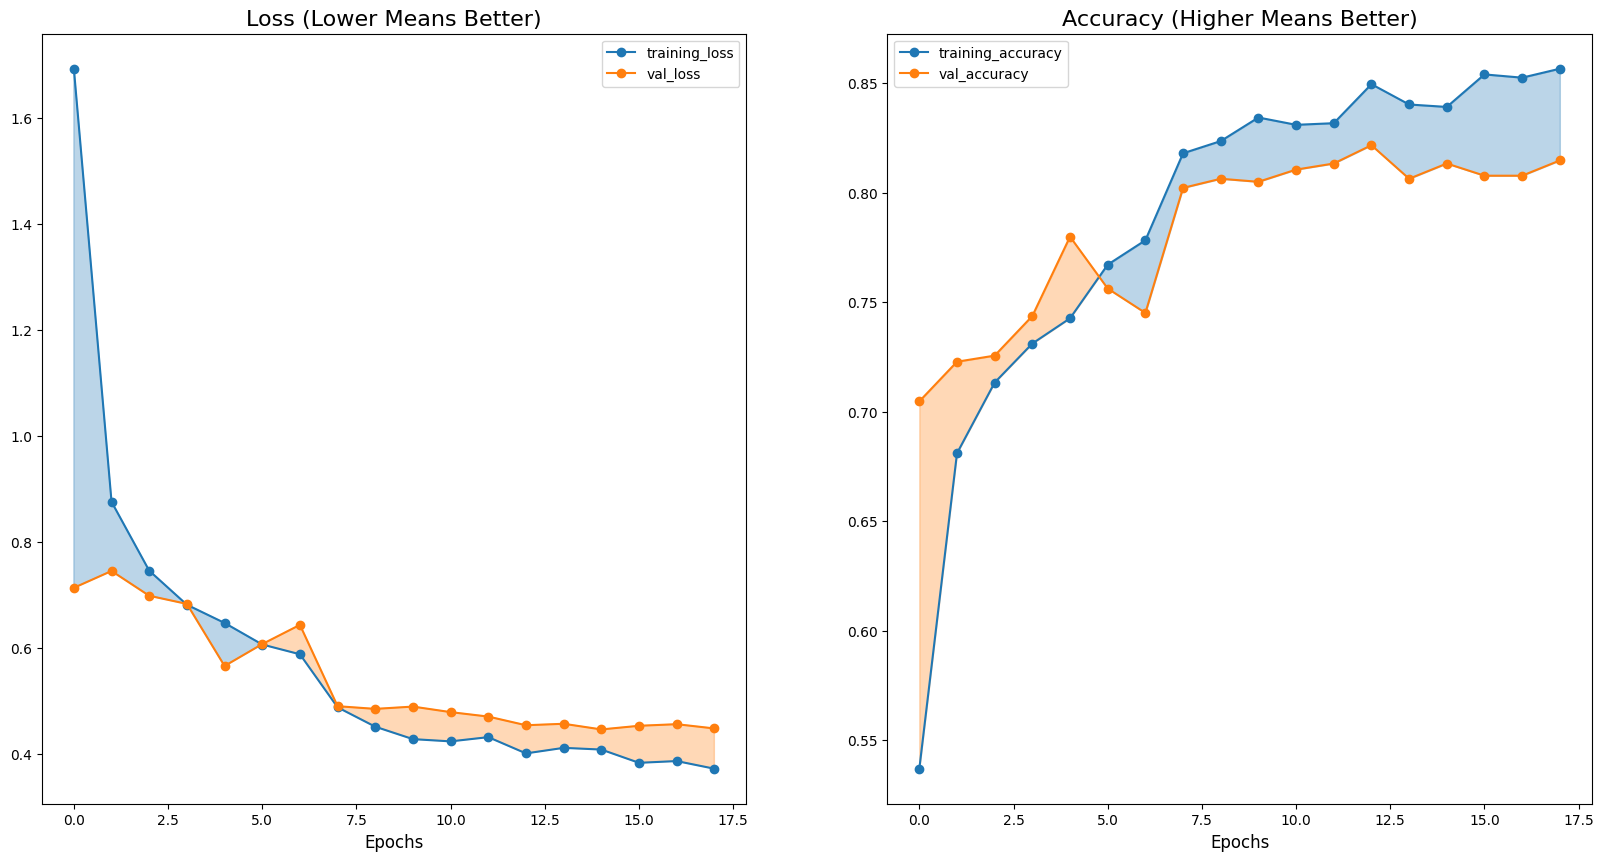

In [191]:
# Plot EfficientNet V2 B0 model training history 
plot_training_curves(resnet_history)
plt.savefig(f'/kaggle/working/resnet_graph.jpg')

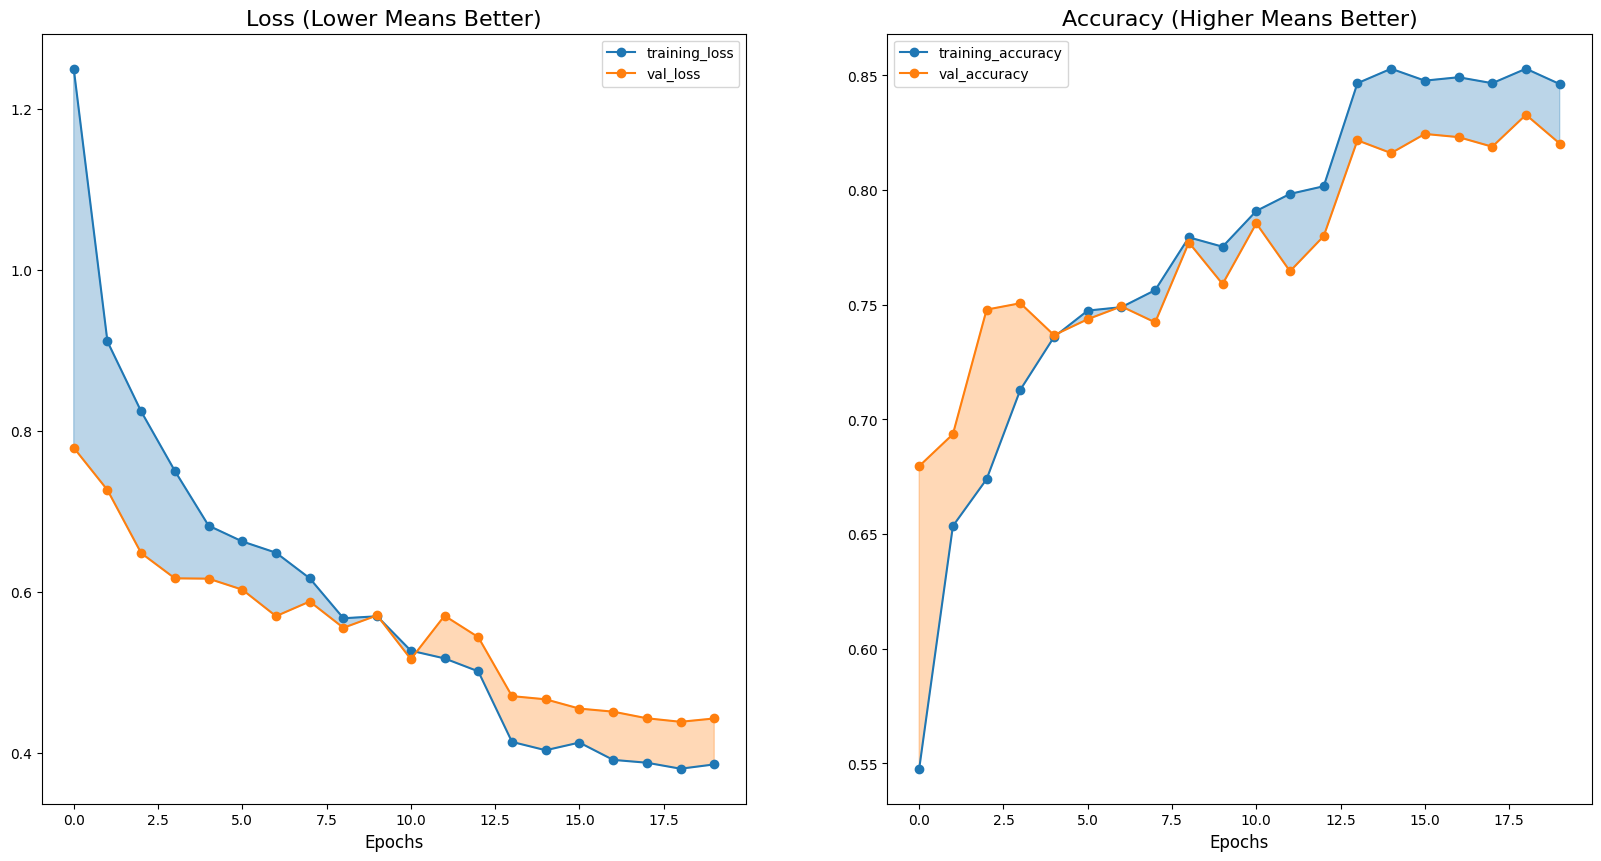

In [192]:
# Plot VIT B16 model training history 
plot_training_curves(vit_b16_history)
plt.savefig(f'/kaggle/working/vit_graph.jpg')

### Plot Confusion Matrix

In [193]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 

    # Plot confusion matrix
    plt.show()
    plt.savefig(f'/kaggle/working/plot_confussion_densenet.jpg')
    
    
    return

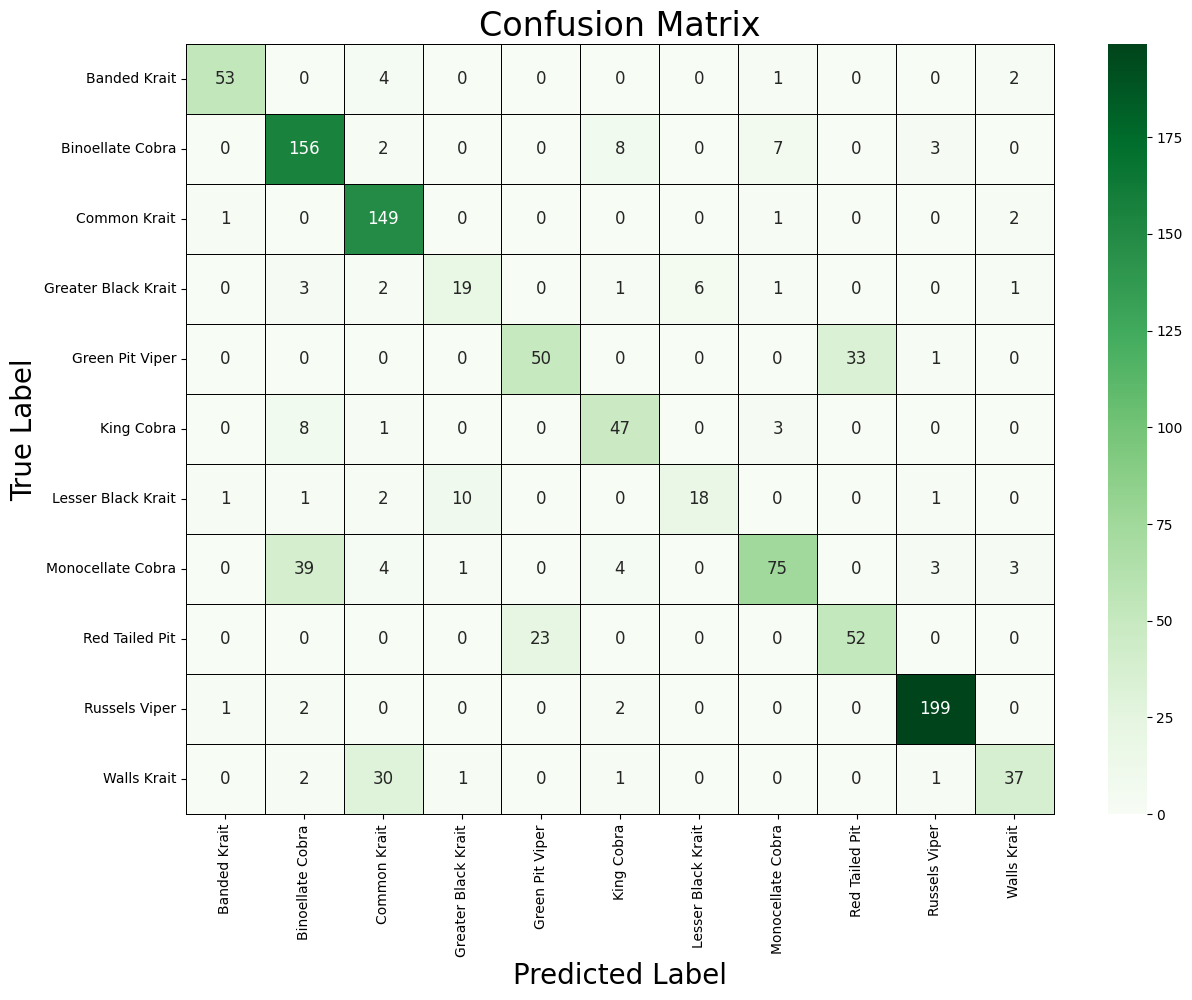

<Figure size 640x480 with 0 Axes>

In [194]:
plot_confusion_matrix(
    test_df.label_encoded, 
    densenet_test_predictions, 
    figsize=(14, 10),  
    classes=class_names)


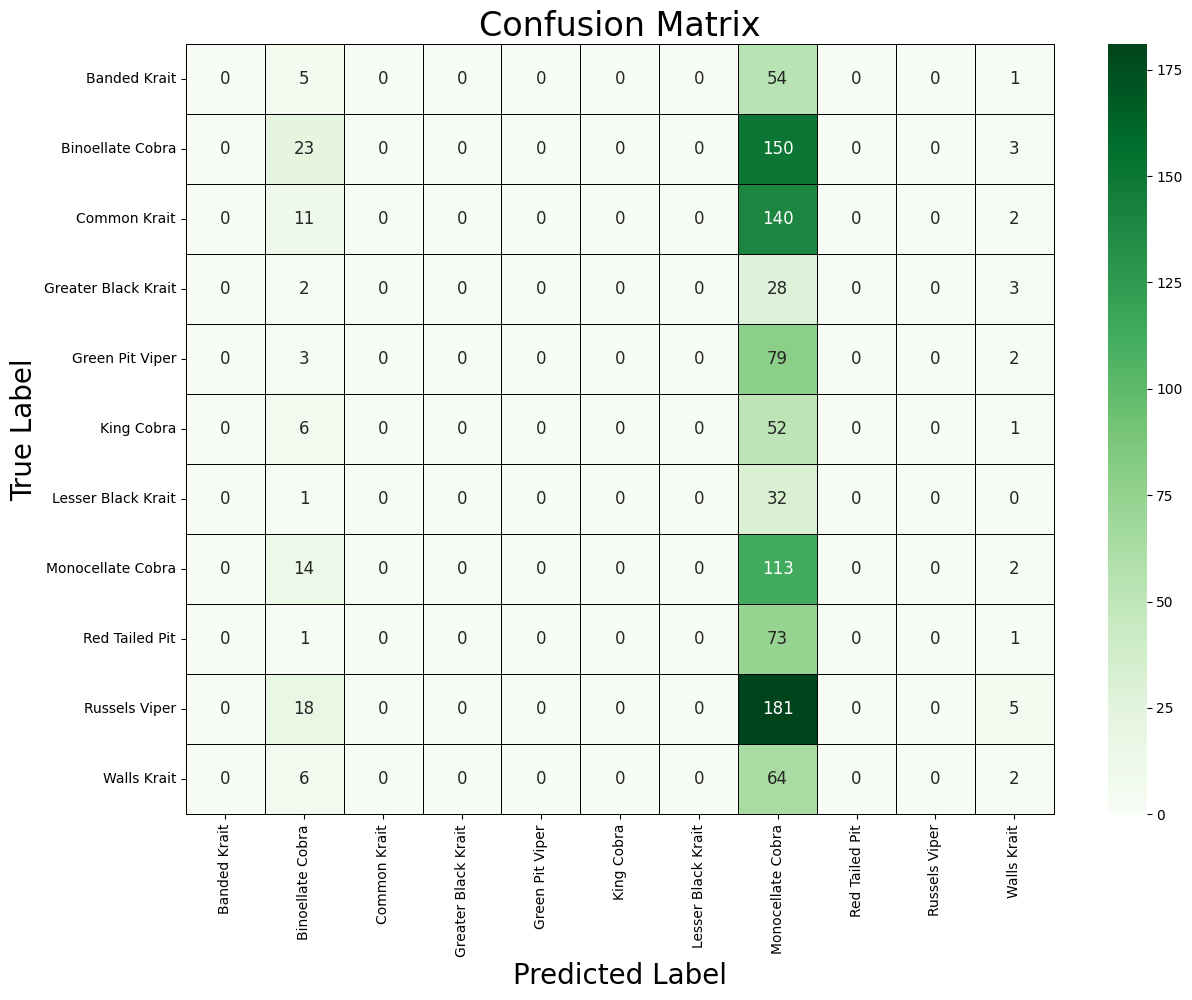

<Figure size 640x480 with 0 Axes>

In [195]:
plot_confusion_matrix(
    test_df.label_encoded, 
    vgg16_test_predictions, 
    figsize=(14, 10),  
    classes=class_names)
plt.savefig(f'/kaggle/working/vgg16_confusion_matrix.jpg')

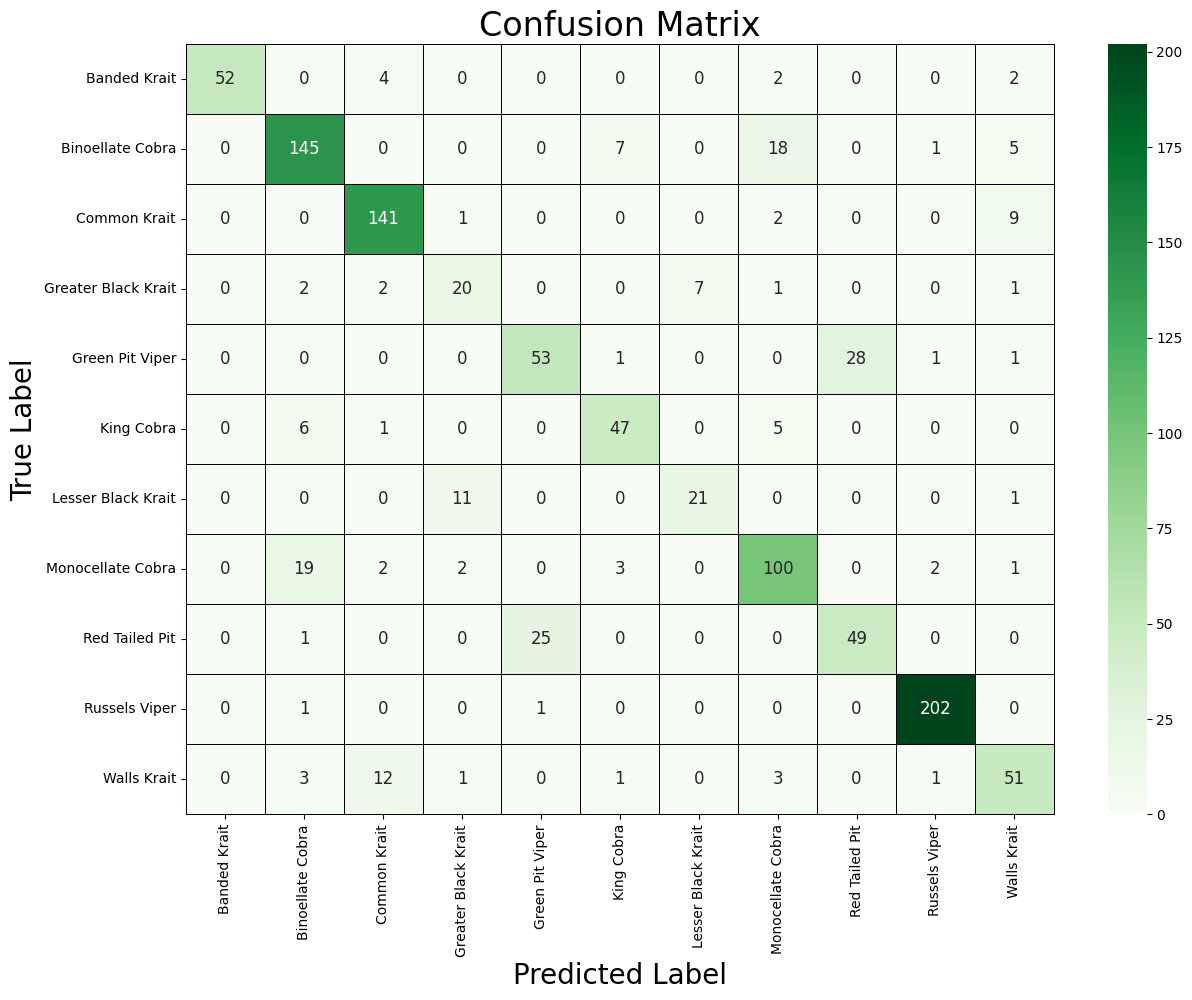

<Figure size 640x480 with 0 Axes>

In [196]:
plot_confusion_matrix(
    test_df.label_encoded, 
    mobilenet_v2_test_predictions, 
    figsize=(14, 10),  
    classes=class_names)
plt.savefig(f'/kaggle/working/mobilenet_confusion_matrix.jpg')

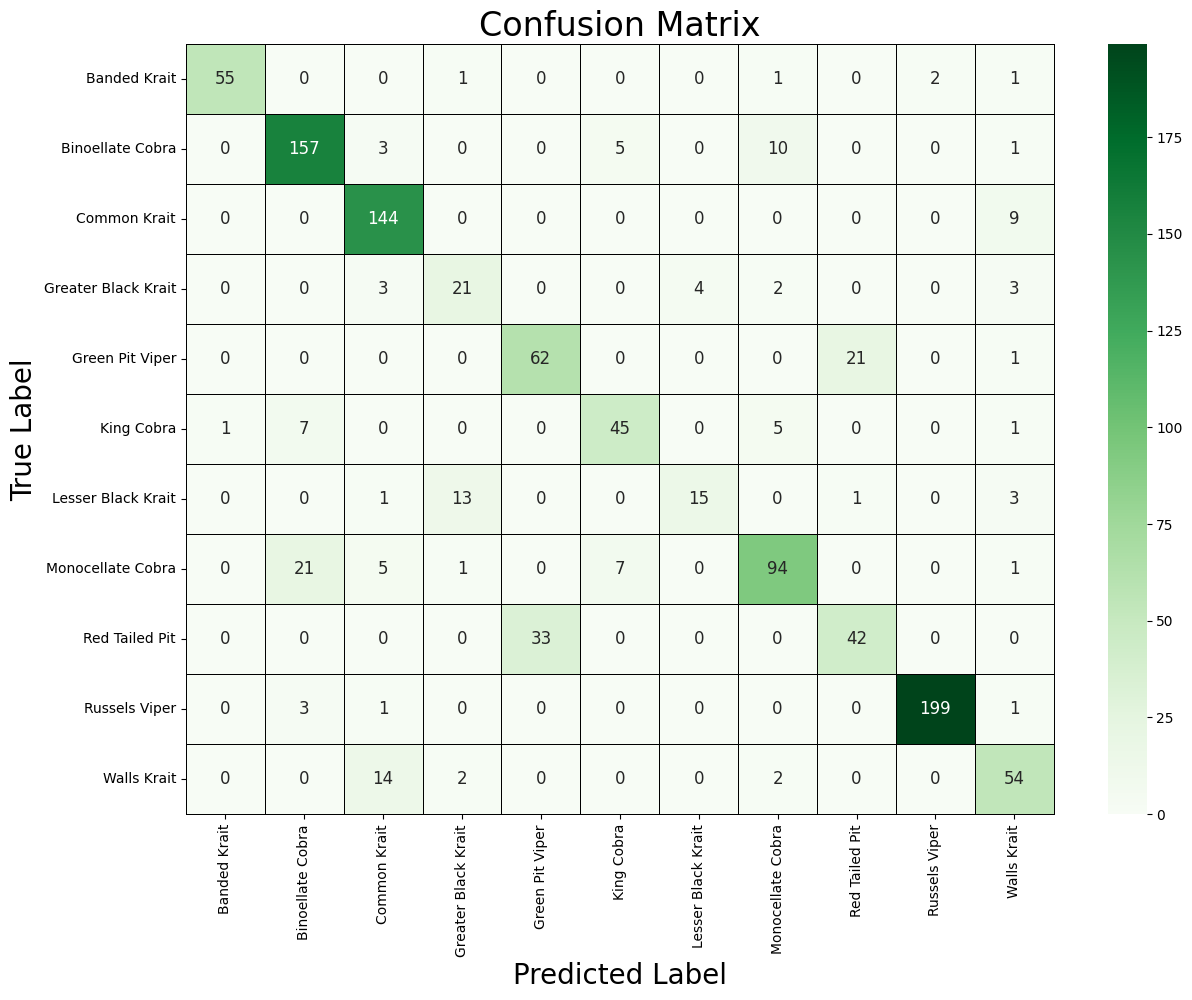

<Figure size 640x480 with 0 Axes>

In [197]:
plot_confusion_matrix(
    test_df.label_encoded, 
    resnet_test_predictions, 
    figsize=(14, 10),  
    classes=class_names)
plt.savefig(f'/kaggle/working/resnet_confusion_matrix.jpg')

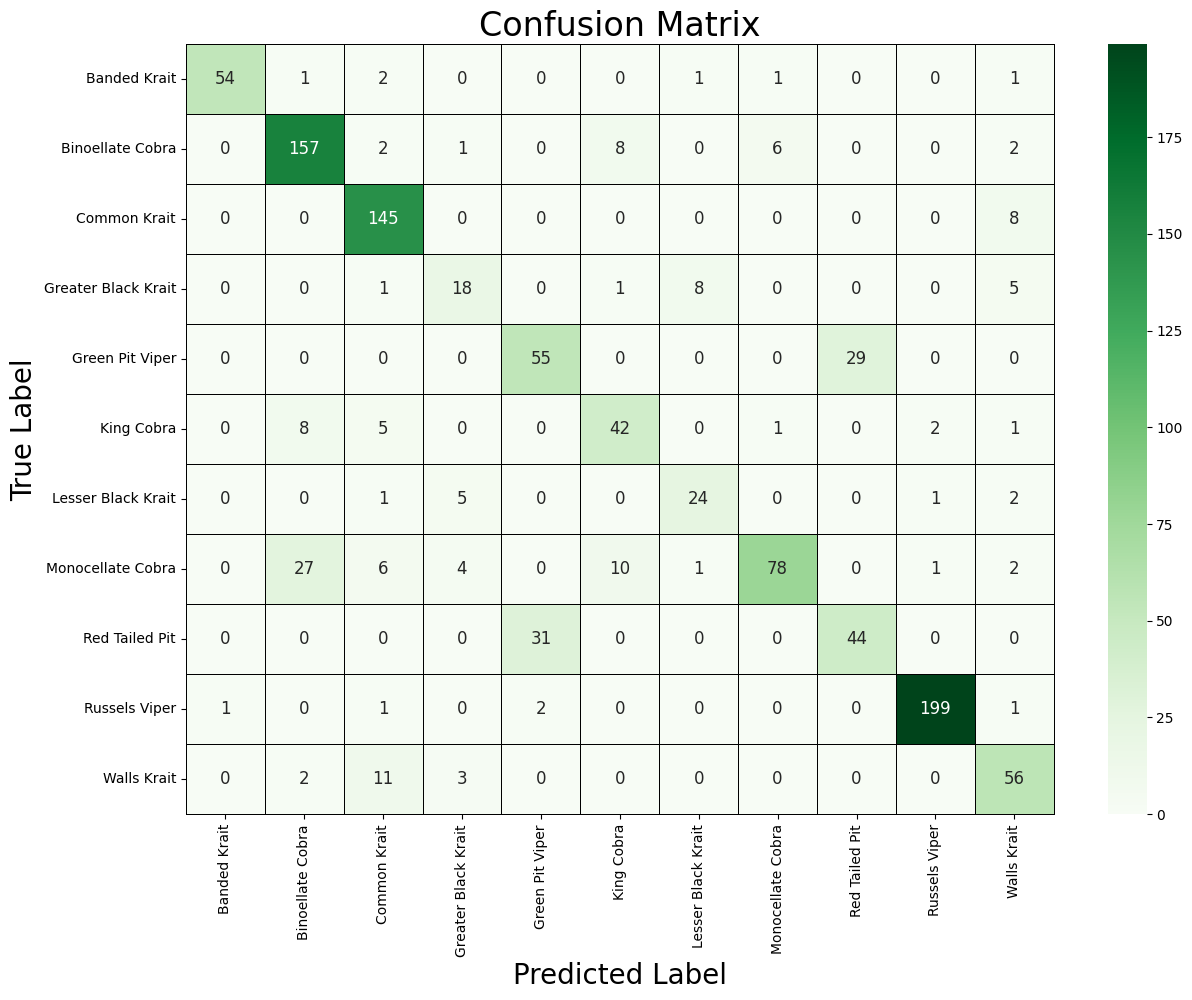

<Figure size 640x480 with 0 Axes>

In [198]:
plot_confusion_matrix(
    test_df.label_encoded, 
    vit_b16_test_predictions, 
    figsize=(14, 10), 
    classes=class_names)
plt.savefig(f'/kaggle/working/vit_confusion_matrix.jpg')

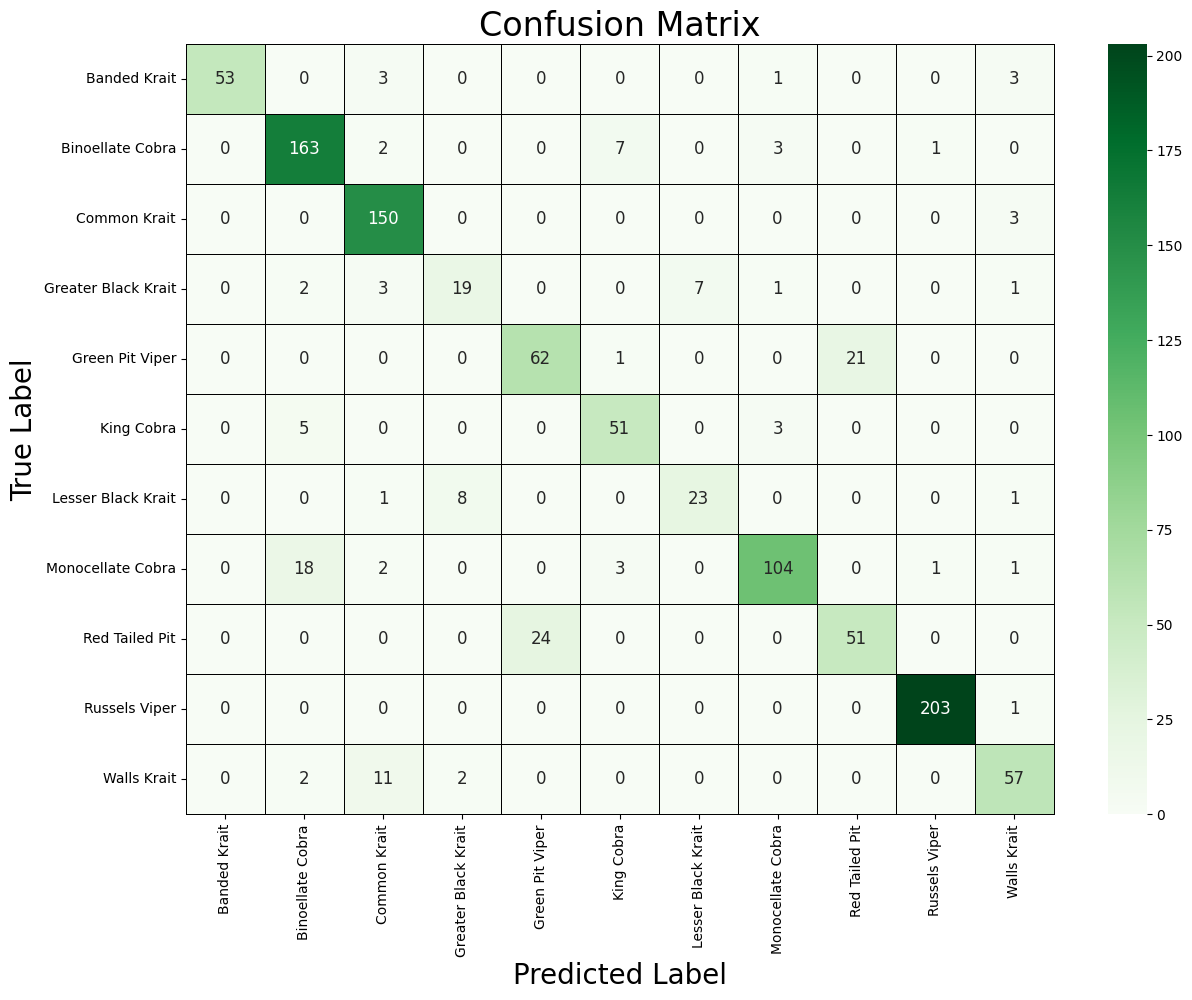

<Figure size 640x480 with 0 Axes>

In [199]:
plot_confusion_matrix(
    test_df.label_encoded, 
    avg_predictions, 
    figsize=(14, 10), 
    classes=class_names)
plt.savefig(f'/kaggle/working/avg_confusion_matrix.jpg')

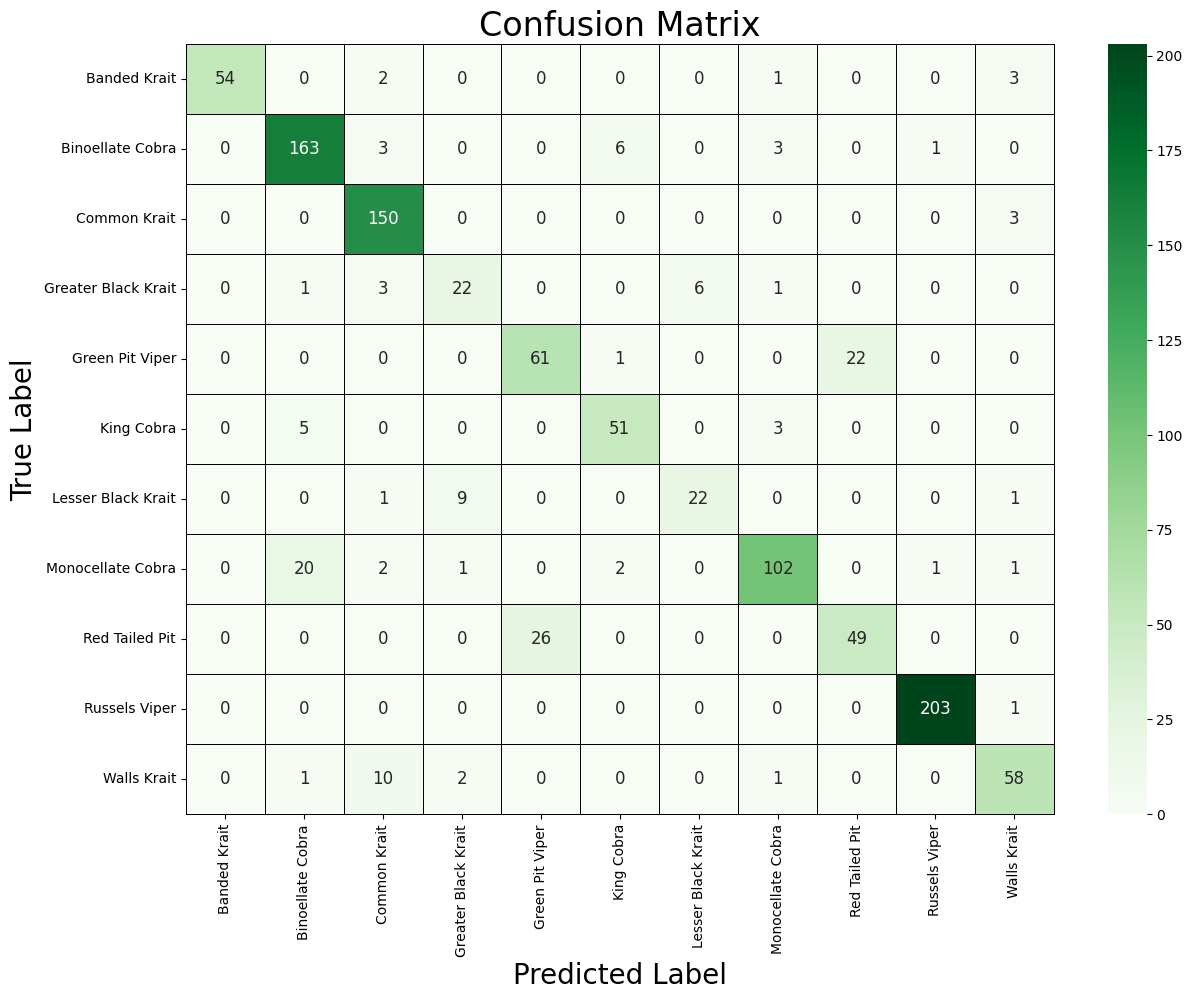

<Figure size 640x480 with 0 Axes>

In [200]:
plot_confusion_matrix(
    test_df.label_encoded, 
    weighted_avg_predictions, 
    figsize=(14, 10), 
    classes=class_names)

plt.savefig(f'/kaggle/working/weight_confusion_matrix.jpg')

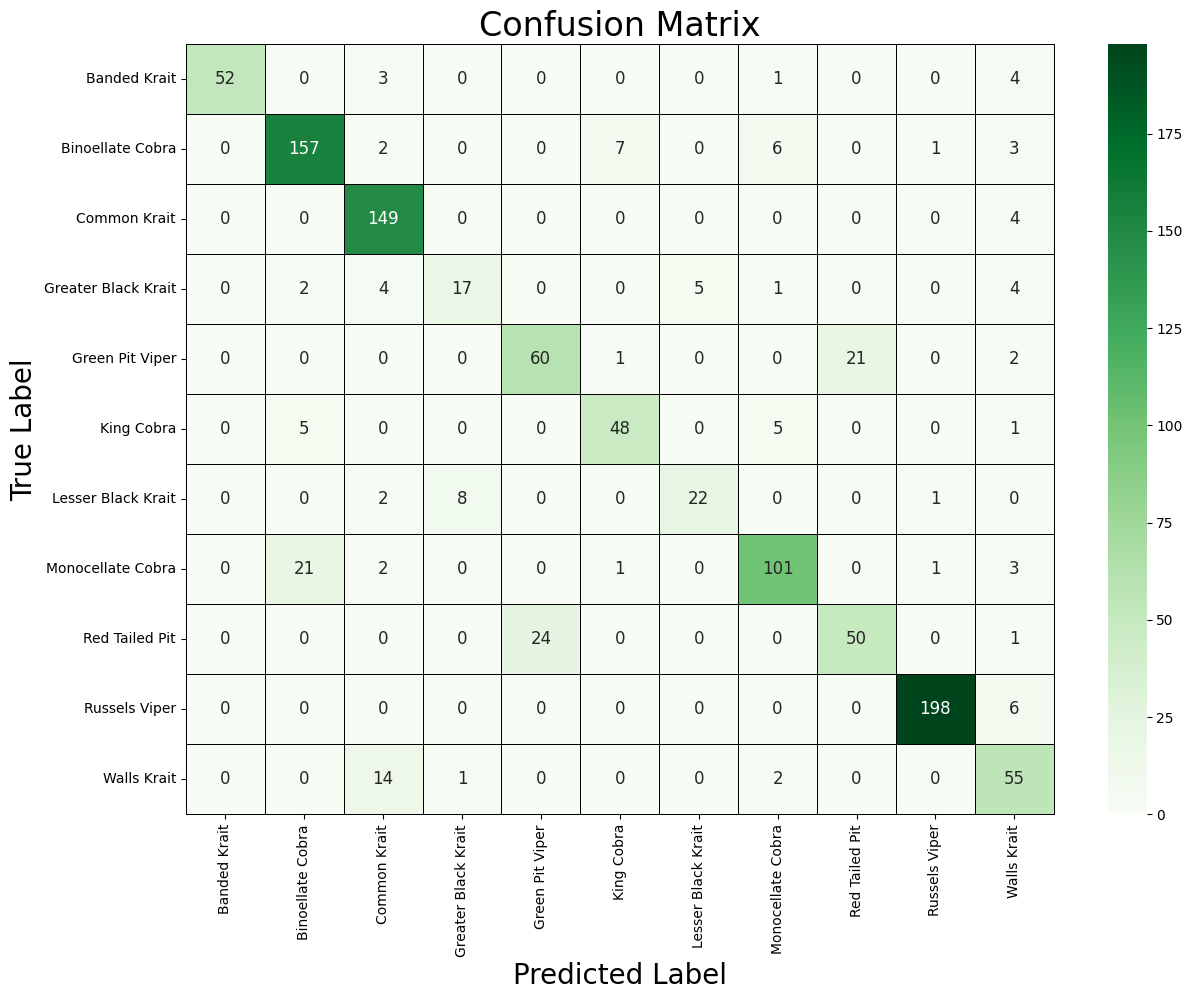

<Figure size 640x480 with 0 Axes>

In [201]:
plot_confusion_matrix(
    test_df.label_encoded, 
    geometric_mean_predictions, 
    figsize=(14, 10), 
    classes=class_names)
plt.savefig(f'/kaggle/working/geometric_mean_confusion_matrix.jpg')

In [202]:
# Densenet Report
print(classification_report(test_df.label_encoded, 
                            densenet_test_predictions, 
                            target_names=class_names))

                     precision    recall  f1-score   support

       Banded Krait       0.95      0.88      0.91        60
   Binoellate Cobra       0.74      0.89      0.81       176
       Common Krait       0.77      0.97      0.86       153
Greater Black Krait       0.61      0.58      0.59        33
    Green Pit Viper       0.68      0.60      0.64        84
         King Cobra       0.75      0.80      0.77        59
 Lesser Black Krait       0.75      0.55      0.63        33
  Monocellate Cobra       0.85      0.58      0.69       129
     Red Tailed Pit       0.61      0.69      0.65        75
      Russels Viper       0.96      0.98      0.97       204
        Walls Krait       0.82      0.51      0.63        72

           accuracy                           0.79      1078
          macro avg       0.77      0.73      0.74      1078
       weighted avg       0.80      0.79      0.79      1078



In [203]:
# vgg16 Report
print(classification_report(test_df.label_encoded, 
                            vgg16_test_predictions, 
                            target_names=class_names))

                     precision    recall  f1-score   support

       Banded Krait       0.00      0.00      0.00        60
   Binoellate Cobra       0.26      0.13      0.17       176
       Common Krait       0.00      0.00      0.00       153
Greater Black Krait       0.00      0.00      0.00        33
    Green Pit Viper       0.00      0.00      0.00        84
         King Cobra       0.00      0.00      0.00        59
 Lesser Black Krait       0.00      0.00      0.00        33
  Monocellate Cobra       0.12      0.88      0.21       129
     Red Tailed Pit       0.00      0.00      0.00        75
      Russels Viper       0.00      0.00      0.00       204
        Walls Krait       0.09      0.03      0.04        72

           accuracy                           0.13      1078
          macro avg       0.04      0.09      0.04      1078
       weighted avg       0.06      0.13      0.06      1078



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [204]:
# mobilenet V2 Report
print(classification_report(test_df.label_encoded, 
                            mobilenet_v2_test_predictions, 
                            target_names=class_names))

                     precision    recall  f1-score   support

       Banded Krait       1.00      0.87      0.93        60
   Binoellate Cobra       0.82      0.82      0.82       176
       Common Krait       0.87      0.92      0.90       153
Greater Black Krait       0.57      0.61      0.59        33
    Green Pit Viper       0.67      0.63      0.65        84
         King Cobra       0.80      0.80      0.80        59
 Lesser Black Krait       0.75      0.64      0.69        33
  Monocellate Cobra       0.76      0.78      0.77       129
     Red Tailed Pit       0.64      0.65      0.64        75
      Russels Viper       0.98      0.99      0.98       204
        Walls Krait       0.72      0.71      0.71        72

           accuracy                           0.82      1078
          macro avg       0.78      0.76      0.77      1078
       weighted avg       0.82      0.82      0.82      1078



In [205]:
# Resnet V2 Report
print(classification_report(test_df.label_encoded, 
                            resnet_test_predictions, 
                            target_names=class_names))

                     precision    recall  f1-score   support

       Banded Krait       0.98      0.92      0.95        60
   Binoellate Cobra       0.84      0.89      0.86       176
       Common Krait       0.84      0.94      0.89       153
Greater Black Krait       0.55      0.64      0.59        33
    Green Pit Viper       0.65      0.74      0.69        84
         King Cobra       0.79      0.76      0.78        59
 Lesser Black Krait       0.79      0.45      0.58        33
  Monocellate Cobra       0.82      0.73      0.77       129
     Red Tailed Pit       0.66      0.56      0.60        75
      Russels Viper       0.99      0.98      0.98       204
        Walls Krait       0.72      0.75      0.73        72

           accuracy                           0.82      1078
          macro avg       0.78      0.76      0.77      1078
       weighted avg       0.83      0.82      0.82      1078



In [206]:
# ViT-b16 Report
print(classification_report(test_df.label_encoded, 
                            vit_b16_test_predictions, 
                            target_names=class_names))

                     precision    recall  f1-score   support

       Banded Krait       0.98      0.90      0.94        60
   Binoellate Cobra       0.81      0.89      0.85       176
       Common Krait       0.83      0.95      0.89       153
Greater Black Krait       0.58      0.55      0.56        33
    Green Pit Viper       0.62      0.65      0.64        84
         King Cobra       0.69      0.71      0.70        59
 Lesser Black Krait       0.71      0.73      0.72        33
  Monocellate Cobra       0.91      0.60      0.73       129
     Red Tailed Pit       0.60      0.59      0.59        75
      Russels Viper       0.98      0.98      0.98       204
        Walls Krait       0.72      0.78      0.75        72

           accuracy                           0.81      1078
          macro avg       0.77      0.76      0.76      1078
       weighted avg       0.81      0.81      0.81      1078



In [207]:
# Average Ensemble Report
print(classification_report(test_df.label_encoded, 
                            avg_predictions, 
                            target_names=class_names))

                     precision    recall  f1-score   support

       Banded Krait       1.00      0.88      0.94        60
   Binoellate Cobra       0.86      0.93      0.89       176
       Common Krait       0.87      0.98      0.92       153
Greater Black Krait       0.66      0.58      0.61        33
    Green Pit Viper       0.72      0.74      0.73        84
         King Cobra       0.82      0.86      0.84        59
 Lesser Black Krait       0.77      0.70      0.73        33
  Monocellate Cobra       0.93      0.81      0.86       129
     Red Tailed Pit       0.71      0.68      0.69        75
      Russels Viper       0.99      1.00      0.99       204
        Walls Krait       0.85      0.79      0.82        72

           accuracy                           0.87      1078
          macro avg       0.83      0.81      0.82      1078
       weighted avg       0.87      0.87      0.87      1078



In [208]:
# Weighted Average Ensemble Report
print(classification_report(test_df.label_encoded, 
                            weighted_avg_predictions, 
                            target_names=class_names))

                     precision    recall  f1-score   support

       Banded Krait       1.00      0.90      0.95        60
   Binoellate Cobra       0.86      0.93      0.89       176
       Common Krait       0.88      0.98      0.93       153
Greater Black Krait       0.65      0.67      0.66        33
    Green Pit Viper       0.70      0.73      0.71        84
         King Cobra       0.85      0.86      0.86        59
 Lesser Black Krait       0.79      0.67      0.72        33
  Monocellate Cobra       0.92      0.79      0.85       129
     Red Tailed Pit       0.69      0.65      0.67        75
      Russels Viper       0.99      1.00      0.99       204
        Walls Krait       0.87      0.81      0.83        72

           accuracy                           0.87      1078
          macro avg       0.83      0.82      0.82      1078
       weighted avg       0.87      0.87      0.87      1078



In [209]:
# Geometric Mean Ensemble Report
print(classification_report(test_df.label_encoded, 
                            geometric_mean_predictions, 
                            target_names=class_names))

                     precision    recall  f1-score   support

       Banded Krait       1.00      0.87      0.93        60
   Binoellate Cobra       0.85      0.89      0.87       176
       Common Krait       0.85      0.97      0.91       153
Greater Black Krait       0.65      0.52      0.58        33
    Green Pit Viper       0.71      0.71      0.71        84
         King Cobra       0.84      0.81      0.83        59
 Lesser Black Krait       0.81      0.67      0.73        33
  Monocellate Cobra       0.87      0.78      0.82       129
     Red Tailed Pit       0.70      0.67      0.68        75
      Russels Viper       0.99      0.97      0.98       204
        Walls Krait       0.66      0.76      0.71        72

           accuracy                           0.84      1078
          macro avg       0.81      0.78      0.80      1078
       weighted avg       0.84      0.84      0.84      1078



In [210]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = accuracy_score(y_true, y_pred)
    top_3_accuracy = top_k_accuracy_score(y_true, y_probabilities, k=3)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, 
                                                                                 y_pred, 
                                                                                 average="weighted")
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'top_3_accuracy_score:\t{top_3_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.4f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print('=============================================')
    
    preformance_scores = {
        'accuracy_score': model_accuracy,
        'top_3_accuracy': top_3_accuracy,
        'precision_score': model_precision,
        'recall_score': model_recall,
        'f1_score': model_f1,
        'matthews_corrcoef': model_matthews_corrcoef
    }
    return preformance_scores


In [211]:
# Generate Densenet model performance scores
densenet_performance = generate_preformance_scores(test_df.label_encoded,
                                                          densenet_test_predictions, 
                                                          densenet_test_probabilities)


Performance Metrics:

accuracy_score:		0.7931

_____________________________________________
top_3_accuracy_score:	0.9768

_____________________________________________
precision_score:	0.7988

_____________________________________________
recall_score:		0.7931

_____________________________________________
f1_score:		0.7867

_____________________________________________
matthews_corrcoef:	0.7657



In [212]:
# Generate Vgg16 model performance scores
vgg16_performance = generate_preformance_scores(test_df.label_encoded,
                                                          vgg16_test_predictions, 
                                                          vgg16_test_probabilities)


Performance Metrics:

accuracy_score:		0.1280

_____________________________________________
top_3_accuracy_score:	0.5380

_____________________________________________
precision_score:	0.0618

_____________________________________________
recall_score:		0.1280

_____________________________________________
f1_score:		0.0558

_____________________________________________
matthews_corrcoef:	0.0142



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [213]:
# Generate MobileNet model performance scores
mobilenet_v2_performance = generate_preformance_scores(test_df.label_encoded,
                                                          mobilenet_v2_test_predictions, 
                                                          mobilenet_v2_test_probabilities)


Performance Metrics:

accuracy_score:		0.8173

_____________________________________________
top_3_accuracy_score:	0.9759

_____________________________________________
precision_score:	0.8175

_____________________________________________
recall_score:		0.8173

_____________________________________________
f1_score:		0.8168

_____________________________________________
matthews_corrcoef:	0.7921



In [214]:
# Generate Resnet model performance scores
resnet_performance = generate_preformance_scores(test_df.label_encoded,
                                                          resnet_test_predictions, 
                                                          resnet_test_probabilities)


Performance Metrics:

accuracy_score:		0.8237

_____________________________________________
top_3_accuracy_score:	0.9805

_____________________________________________
precision_score:	0.8255

_____________________________________________
recall_score:		0.8237

_____________________________________________
f1_score:		0.8217

_____________________________________________
matthews_corrcoef:	0.7997



In [215]:
# Generate ViT model performance scores
vit_b16_performance = generate_preformance_scores(test_df.label_encoded,
                                                  vit_b16_test_predictions, 
                                                  vit_b16_test_probabilities)


Performance Metrics:

accuracy_score:		0.8089

_____________________________________________
top_3_accuracy_score:	0.9861

_____________________________________________
precision_score:	0.8141

_____________________________________________
recall_score:		0.8089

_____________________________________________
f1_score:		0.8067

_____________________________________________
matthews_corrcoef:	0.7836



In [216]:
# Generate Average Ensemble performance scores
avg_ensemble_performance = generate_preformance_scores(test_df.label_encoded,
                                                       avg_predictions, 
                                                       avg_probabilities)


Performance Metrics:

accuracy_score:		0.8683

_____________________________________________
top_3_accuracy_score:	0.9870

_____________________________________________
precision_score:	0.8688

_____________________________________________
recall_score:		0.8683

_____________________________________________
f1_score:		0.8669

_____________________________________________
matthews_corrcoef:	0.8503



In [217]:
# Generate Weighted Average Ensemble performance scores
weigthed_avg_ensemble_performance = generate_preformance_scores(test_df.label_encoded,
                                                                weighted_avg_predictions, 
                                                                weighted_avg_probabilities)


Performance Metrics:

accuracy_score:		0.8673

_____________________________________________
top_3_accuracy_score:	0.9870

_____________________________________________
precision_score:	0.8684

_____________________________________________
recall_score:		0.8673

_____________________________________________
f1_score:		0.8663

_____________________________________________
matthews_corrcoef:	0.8493



In [218]:
# Generate Geometric Mean Ensemble performance scores
geometric_mean_ensemble_performance = generate_preformance_scores(test_df.label_encoded,
                                                                geometric_mean_predictions, 
                                                                geometric_mean_probabilities)


Performance Metrics:

accuracy_score:		0.8432

_____________________________________________
top_3_accuracy_score:	0.9722

_____________________________________________
precision_score:	0.8449

_____________________________________________
recall_score:		0.8432

_____________________________________________
f1_score:		0.8420

_____________________________________________
matthews_corrcoef:	0.8218



In [219]:
# Record metrics with DataFrame
performance_df = pd.DataFrame({
    'model_densenet': densenet_performance,
    'model_vgg16': vgg16_performance,
    'model_mobilenet_v2': mobilenet_v2_performance,
    'model_resnet': resnet_performance,
    'model_vit_b16': vit_b16_performance,
    'average_ensemble': avg_ensemble_performance,
    'weigthed_average_ensemble': weigthed_avg_ensemble_performance,
    'geometric_mean_ensemble': geometric_mean_ensemble_performance
}).T

# View Performance DataFrame
performance_df

accuracy_score  top_3_accuracy  precision_score  \
model_densenet                   0.793135        0.976809         0.798835   
model_vgg16                      0.128015        0.538033         0.061793   
model_mobilenet_v2               0.817254        0.975881         0.817533   
model_resnet                     0.823748        0.980519         0.825451   
model_vit_b16                    0.808905        0.986085         0.814071   
average_ensemble                 0.868275        0.987013         0.868836   
weigthed_average_ensemble        0.867347        0.987013         0.868430   
geometric_mean_ensemble          0.843228        0.972171         0.844937   

                           recall_score  f1_score  matthews_corrcoef  
model_densenet                 0.793135  0.786678           0.765748  
model_vgg16                    0.128015  0.055774           0.014171  
model_mobilenet_v2             0.817254  0.816792           0.792050  
model_resnet                   0.823748  0.821655           0.799733  
model_vit_b16                  0.808905  0.806739           0.783577  
average_ensemble               0.868275  0.866918           0.850307  
weigthed_average_ensemble      0.867347  0.866264           0.849279  
geometric_mean_ensemble        0.843228  0.842042           0.821834

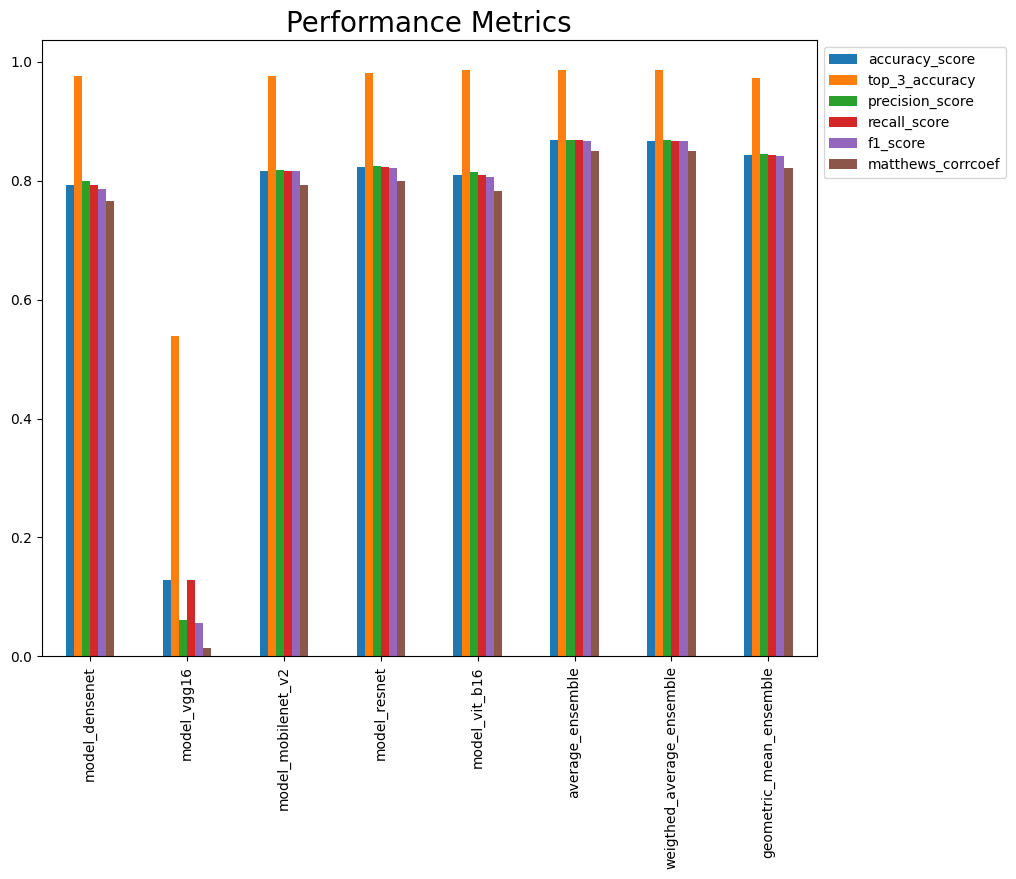

In [220]:
performance_df.plot(kind="bar", figsize=(10, 8)).legend(bbox_to_anchor=(1.0, 1.0))
plt.title('Performance Metrics', fontsize=20);
plt.savefig(f'/kaggle/working/performance_metrics.jpg')

In [221]:
def compute_inference_time(model, ds, sample_count, inference_runs=5):
    total_inference_times = []
    inference_rates = []
    
    for _ in range(inference_runs):
        start = time.perf_counter()
        model.predict(ds, verbose=0)
        end = time.perf_counter() 
        
        # Compute total inference time
        total_inference_time = end - start
        
        # Compute inference rate
        inference_rate = total_inference_time / sample_count
        
        total_inference_times.append(total_inference_time)
        inference_rates.append(inference_rate)
    
    # Calculate average total inference time with uncertainty
    avg_inference_time = sum(total_inference_times) / len(total_inference_times)
    avg_inference_time_uncertainty = (max(total_inference_times) - min(total_inference_times)) / 2
    
    # Calculate average inference rate with uncertainty
    avg_inference_rate = sum(inference_rates) / len(inference_rates)
    avg_inference_rate_uncertainty = (max(inference_rates) - min(inference_rates)) / 2
    
    print('====================================================')
    print(f'Model:\t\t{model.name}\n')
    print(f'Inference Time:\t{round(avg_inference_time, 6)}s \xB1 {round(avg_inference_time_uncertainty, 6)}s')
    print(f'Inference Rate:\t{round(avg_inference_rate, 6)}s/sample \xB1 {round(avg_inference_rate_uncertainty, 6)}s/sample')
    print('====================================================')
    
    return avg_inference_time, avg_inference_rate

In [222]:
densenet_inference = compute_inference_time(model_densenet, test_ds, len(test_df))

Model:		sequential_2

Inference Time:	4.751024s ± 0.72551s
Inference Rate:	0.004407s/sample ± 0.000673s/sample


In [223]:
vgg16_inference = compute_inference_time(model_vgg16, test_ds, len(test_df))

Model:		sequential_3

Inference Time:	4.038137s ± 0.69125s
Inference Rate:	0.003746s/sample ± 0.000641s/sample


In [224]:
mobilenet_v2_inference = compute_inference_time(model_mobileNet_v2, test_ds, len(test_df))

Model:		mobileNet_v2_sequential_model

Inference Time:	3.6147s ± 1.01005s
Inference Rate:	0.003353s/sample ± 0.000937s/sample


In [225]:
resnet_inference = compute_inference_time(model_resnet, test_ds, len(test_df))

Model:		resnet_sequential_model

Inference Time:	31.576042s ± 9.826181s
Inference Rate:	0.029291s/sample ± 0.009115s/sample


In [226]:
vit_b16_inference = compute_inference_time(model_vit_b16, test_ds, len(test_df))

Model:		vit_b16_sequential_model

Inference Time:	9.668187s ± 0.753289s
Inference Rate:	0.008969s/sample ± 0.000699s/sample


In [227]:
# We assume all ensembles to have the total inference of all models
ensemble_inference = (
    densenet_inference[0] + vgg16_inference[0] + mobilenet_v2_inference[0] + resnet_inference[0] + vit_b16_inference[0],
    densenet_inference[1] + vgg16_inference[1] + mobilenet_v2_inference[1] + resnet_inference[1] + vit_b16_inference[1]
)

print('====================================================')
print(f'Model:\t\tAverage/Weighted Average Ensemble\n')
print(f'Inference Time:\t{ensemble_inference[0]:.6f}s')
print(f'Inference Rate:\t{ensemble_inference[1]:.6f}s/sample')
print('====================================================')

Model:		Average/Weighted Average Ensemble

Inference Time:	53.648089s
Inference Rate:	0.049766s/sample


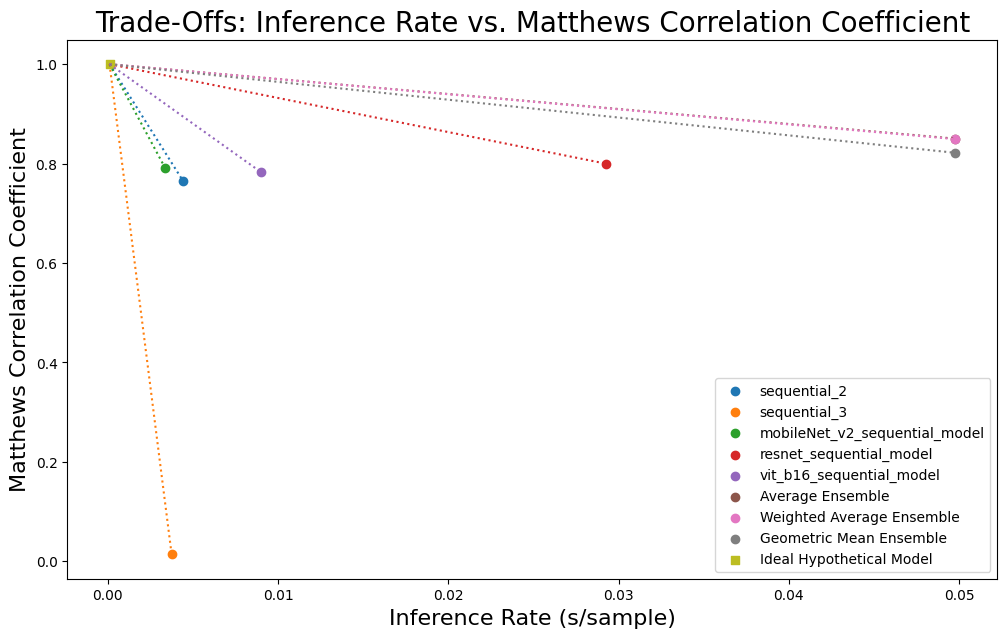

In [228]:
# Get MCC for each model
densenet_mcc = densenet_performance["matthews_corrcoef"]
vgg16_mcc = vgg16_performance["matthews_corrcoef"]
mobilenet_mcc = mobilenet_v2_performance["matthews_corrcoef"]
resnet_mcc = resnet_performance["matthews_corrcoef"]
vit_mcc = vit_b16_performance["matthews_corrcoef"]
avg_mcc = avg_ensemble_performance['matthews_corrcoef']
weighted_mcc = weigthed_avg_ensemble_performance['matthews_corrcoef']
geometric_mcc = geometric_mean_ensemble_performance['matthews_corrcoef']

# Scatter plot inference rate against MCC
plt.figure(figsize=(12, 7))

# plt.scatter(cnn_inference[1], cnn_mcc, label=model_cnn.name)
plt.scatter(densenet_inference[1], densenet_mcc, label=model_densenet.name)
plt.scatter(vgg16_inference[1], vgg16_mcc, label=model_vgg16.name)
plt.scatter(mobilenet_v2_inference[1], mobilenet_mcc, label=model_mobileNet_v2.name)
plt.scatter(resnet_inference[1], resnet_mcc, label=model_resnet.name)
plt.scatter(vit_b16_inference[1], vit_mcc, label=model_vit_b16.name)
plt.scatter(ensemble_inference[1], avg_mcc, label='Average Ensemble')
plt.scatter(ensemble_inference[1], weighted_mcc, label='Weighted Average Ensemble')
plt.scatter(ensemble_inference[1], geometric_mcc, label='Geometric Mean Ensemble')

ideal_inference_rate = 0.0001 # Desired inference time (Exaggerated)
ideal_mcc = 1 # Max MCC 

# Plot lines connecting each model coords. to the ideal model coords.
plt.scatter(ideal_inference_rate, ideal_mcc, label="Ideal Hypothetical Model", marker='s')
plt.plot([ideal_inference_rate, densenet_inference[1]], [ideal_mcc, densenet_mcc], ':')
plt.plot([ideal_inference_rate, vgg16_inference[1]], [ideal_mcc, vgg16_mcc], ':')

plt.plot([ideal_inference_rate, mobilenet_v2_inference[1]], [ideal_mcc, mobilenet_mcc], ':')
plt.plot([ideal_inference_rate, resnet_inference[1]], [ideal_mcc, resnet_mcc], ':')

plt.plot([ideal_inference_rate, vit_b16_inference[1]], [ideal_mcc, vit_mcc], ':')
plt.plot([ideal_inference_rate, ensemble_inference[1]], [ideal_mcc, avg_mcc], ':')
plt.plot([ideal_inference_rate, ensemble_inference[1]], [ideal_mcc, weighted_mcc], ':')
plt.plot([ideal_inference_rate, ensemble_inference[1]], [ideal_mcc, geometric_mcc], ':')

plt.legend()
plt.title("Trade-Offs: Inference Rate vs. Matthews Correlation Coefficient", fontsize=20)
plt.xlabel("Inference Rate (s/sample)", fontsize=16)
plt.ylabel("Matthews Correlation Coefficient", fontsize=16);

In [229]:
def dist(x1, x2, y1, y2):
    return np.sqrt(np.square(x2 - x1) + np.square(y2 - y1))

# List model names
model_names = [
    model_densenet.name, 
    model_vgg16.name, 
    model_mobileNet_v2.name, 
    model_resnet.name, 
    model_vit_b16.name,
    'Average Ensemble',
    'Weighted Average Ensemble',
    'Geometric Mean Ensemble'
]

# List model mcc scores
model_scores = [
    densenet_mcc,
    vgg16_mcc,
    mobilenet_mcc,
    resnet_mcc,
    vit_mcc,
    avg_mcc,
    weighted_mcc,
    geometric_mcc
]

# List model inference rates
model_rates = [
    densenet_inference[1], 
    vgg16_inference[1], 
    mobilenet_v2_inference[1], 
    resnet_inference[1], 
    vit_b16_inference[1],
    ensemble_inference[1],
    ensemble_inference[1],
    ensemble_inference[1]
]

# Compute trade-off's
trade_offs = [dist(ideal_inference_rate, inference_rate, ideal_mcc, score) 
              for inference_rate, score in zip(model_rates, model_scores)]

# View model trade-off scores
print('Trade-Off Score: Inference Rate vs. MCC')
for name, inference_rate, score, trade in zip(model_names, model_rates, model_scores, trade_offs):
    print('---------------------------------------------------------')
    print(f'Model: {name}\n\nInference Rate: {inference_rate:.5f} | MCC: {score:.4f} | Trade-Off: {trade:.4f}')

# View model with best trade-off score
print('=========================================================')
best_model_trade = min(trade_offs)
best_model_name = model_names[np.argmin(trade_offs)]
print(f'\nBest Optimal Model:\t{best_model_name}\nTrade-Off:\t\t{best_model_trade:.4f}\n')
print('=========================================================')

Trade-Off Score: Inference Rate vs. MCC
---------------------------------------------------------
Model: sequential_2

Inference Rate: 0.00441 | MCC: 0.7657 | Trade-Off: 0.2343
---------------------------------------------------------
Model: sequential_3

Inference Rate: 0.00375 | MCC: 0.0142 | Trade-Off: 0.9858
---------------------------------------------------------
Model: mobileNet_v2_sequential_model

Inference Rate: 0.00335 | MCC: 0.7921 | Trade-Off: 0.2080
---------------------------------------------------------
Model: resnet_sequential_model

Inference Rate: 0.02929 | MCC: 0.7997 | Trade-Off: 0.2024
---------------------------------------------------------
Model: vit_b16_sequential_model

Inference Rate: 0.00897 | MCC: 0.7836 | Trade-Off: 0.2166
---------------------------------------------------------
Model: Average Ensemble

Inference Rate: 0.04977 | MCC: 0.8503 | Trade-Off: 0.1577
---------------------------------------------------------
Model: Weighted Average Ensemble

In

In [230]:
import tensorflow.keras
import tensorflow as tf
from PIL import Image, ImageOps
import numpy as np
import keras
import keras.utils
from keras import utils as np_utils
import tensorflow_hub as hub


# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
keras_model_densenet = tensorflow.keras.models.load_model('/kaggle/working/densenet.h5', compile=False)
keras_model_densenet._name = 'model_densenet'
keras_model_vgg16 = tensorflow.keras.models.load_model('/kaggle/working/vgg16.h5', compile=False)
keras_model_vgg16._name = 'model_vgg16'
keras_model_mobilenet = tf.keras.models.load_model(('/kaggle/working/mobilenet.h5'),custom_objects={'KerasLayer':hub.KerasLayer})
keras_model_mobilenet._name = 'model_mobilenet'
keras_model_resnet = keras.models.load_model('/kaggle/working/resnet.h5', compile=False)
keras_model_resnet._name = 'model_resnet'
keras_model_vit = tensorflow.keras.models.load_model('/kaggle/working/vit.h5', compile=False)
keras_model_vit._name = 'model_vit'
models = [keras_model_densenet, keras_model_vgg16, keras_model_mobilenet, keras_model_resnet, keras_model_vit]
model_input = tf.keras.Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

ensemble_model.save('ensemble_vgg_dense_mobilenet_resnet_vit.h5')

OSError: No file or directory found at /kaggle/working/densenet.h5

In [ ]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/ensemble_vgg_dense_mobilenet_resnet_vit.h5')